In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import (NaiveSeasonal, 
                          NBEATSModel, 
                          ARIMA, 
                          TFTModel, 
                          RandomForest, 
                          ExponentialSmoothing)
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, stationarity_test_adf
from darts.metrics import smape
from statsmodels.tsa.seasonal import seasonal_decompose
from darts.utils.statistics import plot_residuals_analysis
from darts.dataprocessing.transformers import Scaler
import optuna
from pytorch_lightning.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX

/opt/miniconda3/envs/sales/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Funcs

In [2]:
def plot_training_val(entire_series, pred, val, model_name = 'Model'):
    fig, (ax1, ax2) = plt.subplots(nrows = 2,ncols = 1, figsize = (12,8))
    entire_series.plot(label="actual", ax = ax1)
    pred.plot(label = 'prediction', ax = ax1, c = 'blue')
    ax1.set_title(f'Entire dataset with predicted values - {model_name}')
    val.plot(label = 'validation', ax = ax2)
    pred.plot(label = 'prediction', ax = ax2, c = 'blue')
    ax2.set_title(f'Actual sales with predicted values - {model_name}')
    fig.tight_layout()
    plt.show()

# Data Injestion

In [3]:
pkl_dir = Path(Path.cwd().parent, "data", "interim", "exploration_df.pkl")
df = pd.read_pickle(pkl_dir)

In [4]:
df = df.set_index('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype    
---  ------      --------------   -----    
 0   store       913000 non-null  int64    
 1   item        913000 non-null  int64    
 2   sales       913000 non-null  int64    
 3   day         913000 non-null  int64    
 4   month       913000 non-null  int64    
 5   year        913000 non-null  int64    
 6   quarter     913000 non-null  int64    
 7   month_year  913000 non-null  period[M]
 8   month_name  120 non-null     object   
dtypes: int64(7), object(1), period[M](1)
memory usage: 69.7+ MB


In [5]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


# Creating a darts timeseries

In [6]:
series_group = TimeSeries.from_group_dataframe(df, 
                                group_cols = ['store', 'item'], 
                    time_col=None, 
                    value_cols='sales', 
                    static_cols=None, 
                    fill_missing_dates=False, 
                    freq='D', 
                    fillna_value=None)

In [7]:
len(series_group)
# one series for each store and product = 10* 50 = 500

500

# Testing first series

In [8]:
single_series = series_group[1] #store 1 item 1
single_series.head()

<TimeSeries (DataArray) (date: 5, component: 1, sample: 1)>
array([[[33.]],

       [[43.]],

       [[23.]],

       [[18.]],

       [[34.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-05
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  store  item\ncomponent            ...
    hierarchy:          None

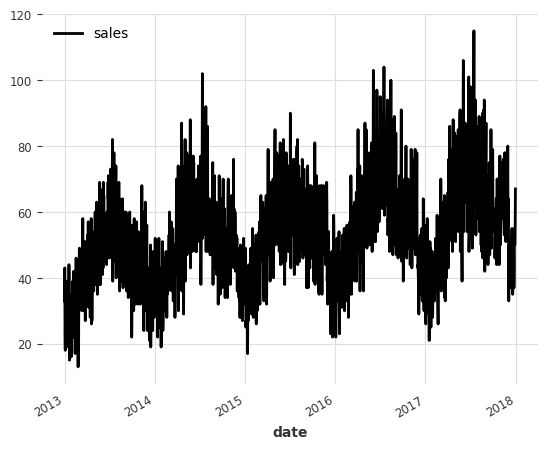

In [9]:
single_series.plot()

# Decomposition

In [10]:
single_df = df[(df['store'] == 1) & (df['item'] == 1)]

With statsmodels we can decompose the sales for a single store and item into seasonal and trend components. 

<Figure size 640x480 with 0 Axes>

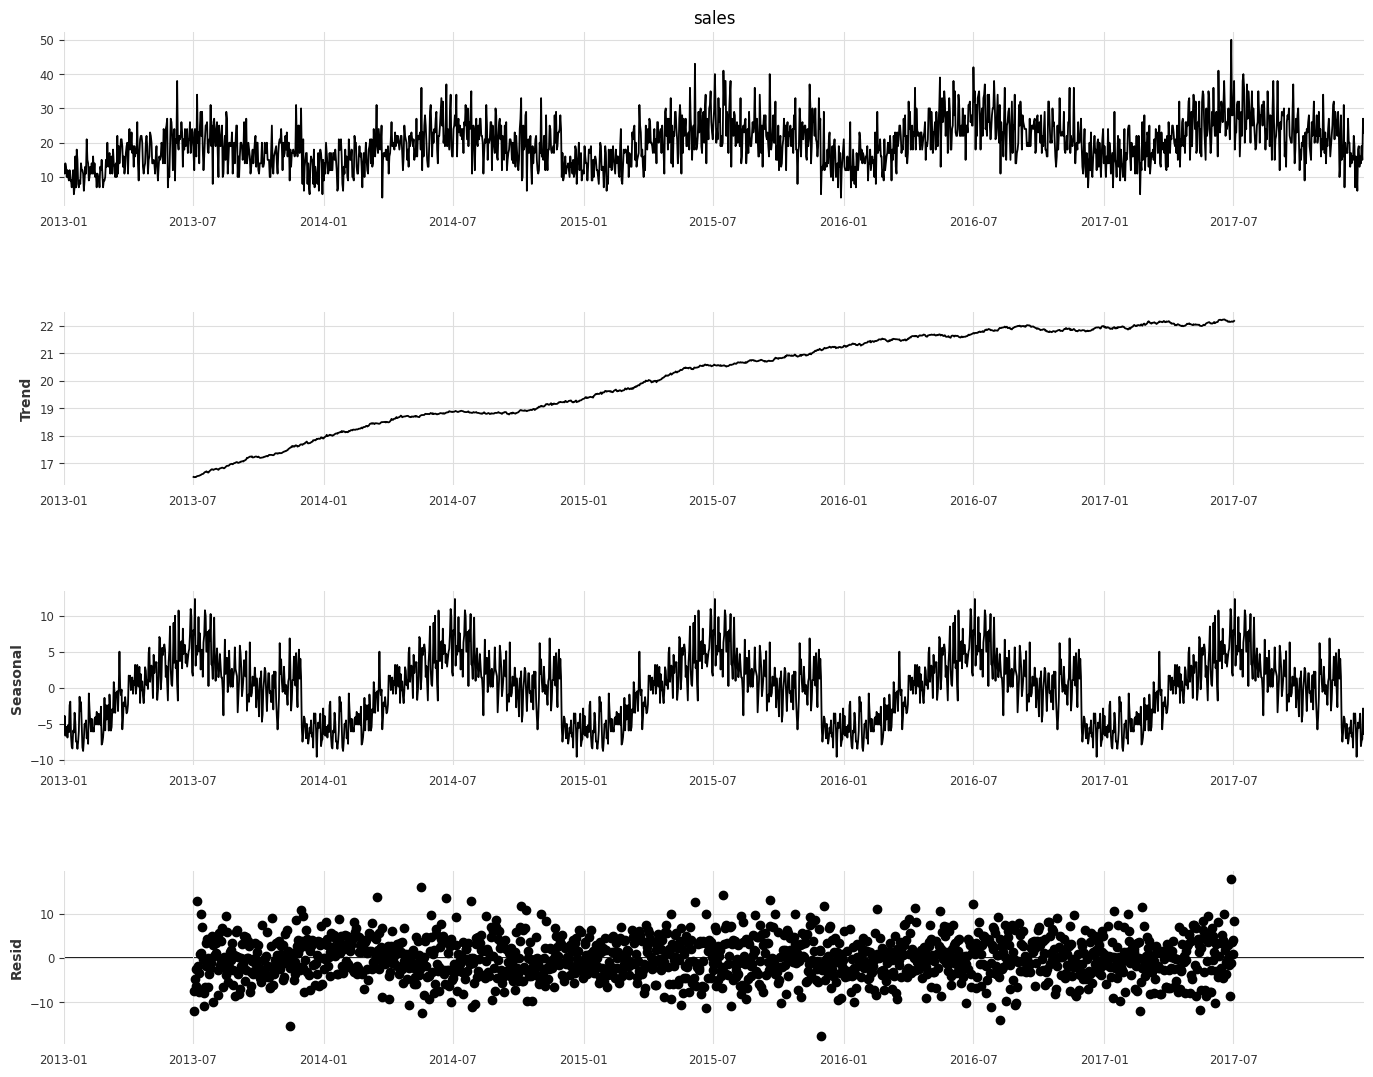

In [11]:
result = seasonal_decompose(single_df['sales'], model='additive', period = 365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

# ACF and PACF

We can test for seasonality by plotting the auto-correlation function (ACF). 
We can plot the ACF for the entire four years of data, highlighting the 1 year period. 

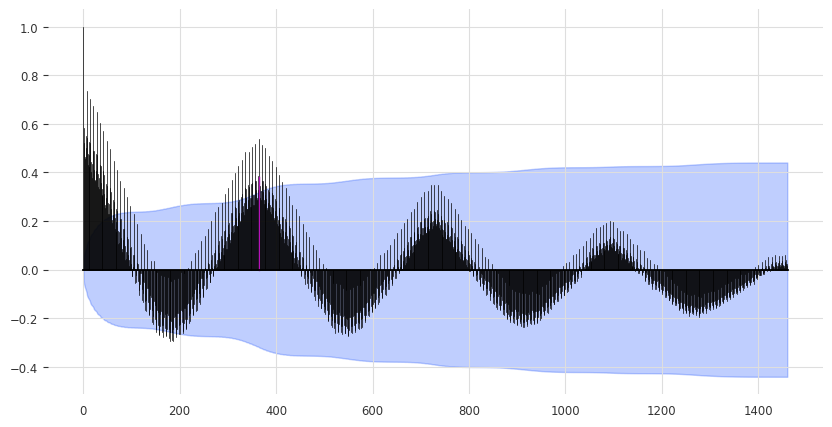

In [12]:
plot_acf(single_series, m = 365, max_lag = 365*4, alpha=0.05)

Based on the decaying ACF, we are likely dealing with an auto regressive model. 

For clarity, we can also inspect the first portion, as this seems to be the most highly correlated. 

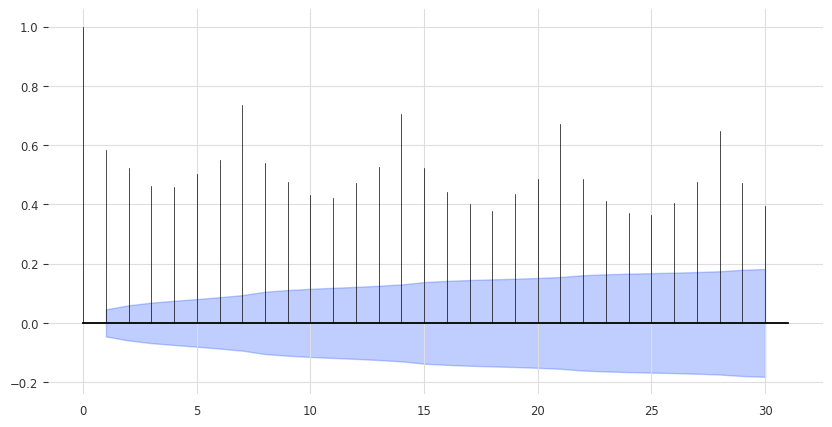

In [13]:
plot_acf(single_series, max_lag = 30, alpha=0.05)



Lets check the PACF for a year to see more concrete evidence. 

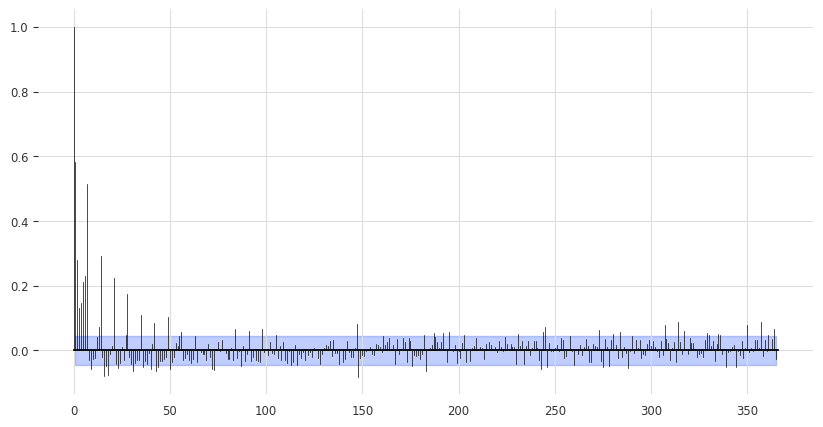

In [14]:
plot_pacf(single_series, max_lag = 365, alpha=0.05)

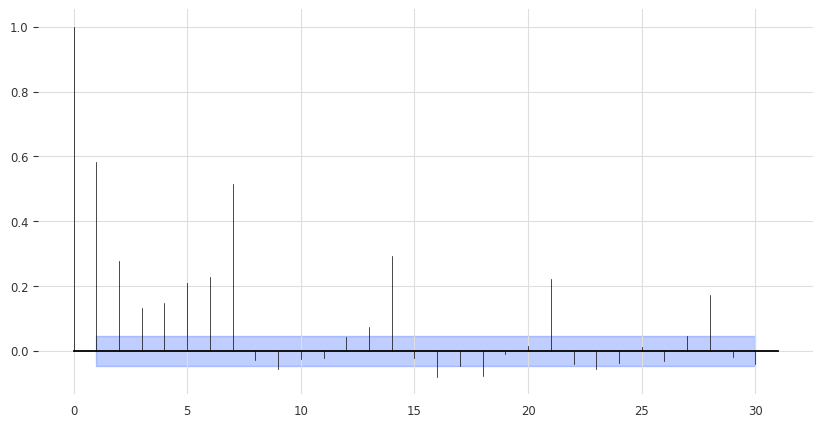

In [15]:
plot_pacf(single_series, max_lag = 30, alpha=0.05)

The blue zone in the above plots indicate statistical significance, and anything inside them can be considered statistically insignificant. 

We can ignore the correlation at point 0, as obviously the current time data is perfectly correlated with itself. 

Both the ACF and PACF indicate the strongest correlation at lag = 7, indicating a weekly trend. This can be confirmed with darts' check_seasonality function. 

In [16]:
check_seasonality(single_series)

(True, 7)

# Basic forecasting

Testing some naive forecasting methods. 
First we need to split intro train/test.

## Train test split

In [17]:
train, val = single_series.split_after(0.75)
len(train), len(val)

(1369, 457)

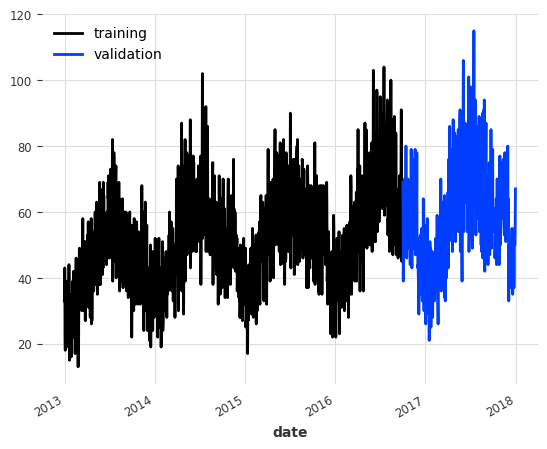

In [18]:
train.plot(label="training")
val.plot(label="validation")

Lets create a dict to hold all of our results for the different models for easy comparison

In [19]:
results_dict = {}

First we'll test a naive seasonal model. 
This is useful to get an idea of the bare minimum accuracy that one could expect. For example, the NaiveSeasonal(K) model always “repeats” the value that occured K time steps ago.

In its most naive form, when K=1, this model simply always repeats the last value of the training series:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


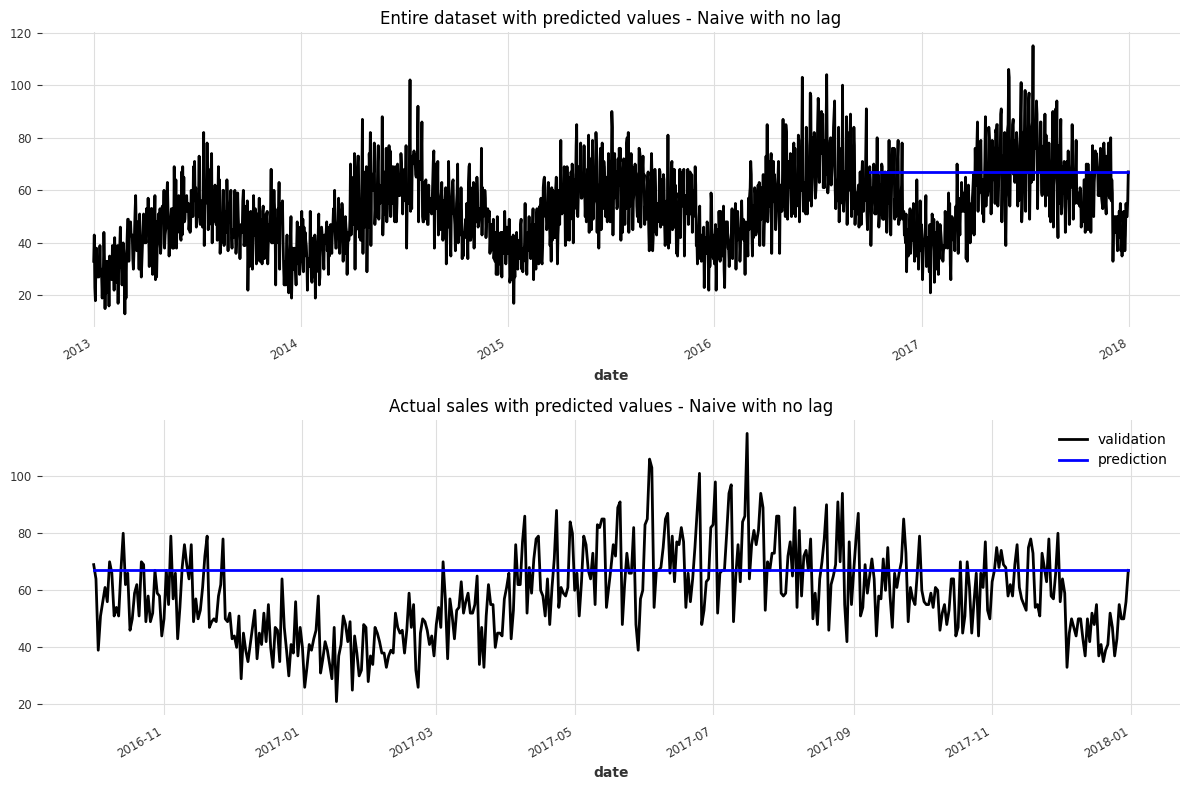

In [20]:
LAG = 1
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = seasonal_forecast, 
                  val = val, 
                  model_name = "Naive with no lag")

For this basic model I'm going to use symmetric Mean Absolute Percentage Error (SMAPE), as this is the metric used in the original kaggle competition. 

In [21]:
print(f"The SMAPE assosciated with the naive seasonal model with no lag is: {smape(single_series, seasonal_forecast):.2f}")
results_dict['naive_no_lag'] = smape(single_series, seasonal_forecast)

The SMAPE assosciated with the naive seasonal model with no lag is: 24.73


Let's try another seasonal naive model using the 7 day lag we identified in the acf and pacf, multiplied out to capture more of the trend. 

I'm going to use 364 days for the lag, as this should capture the entire yearly trend whilst being divisable by our acf/pacf lag identified. 

Using just a 7 day lag when trying to predict over 450 days is not going to cut it. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


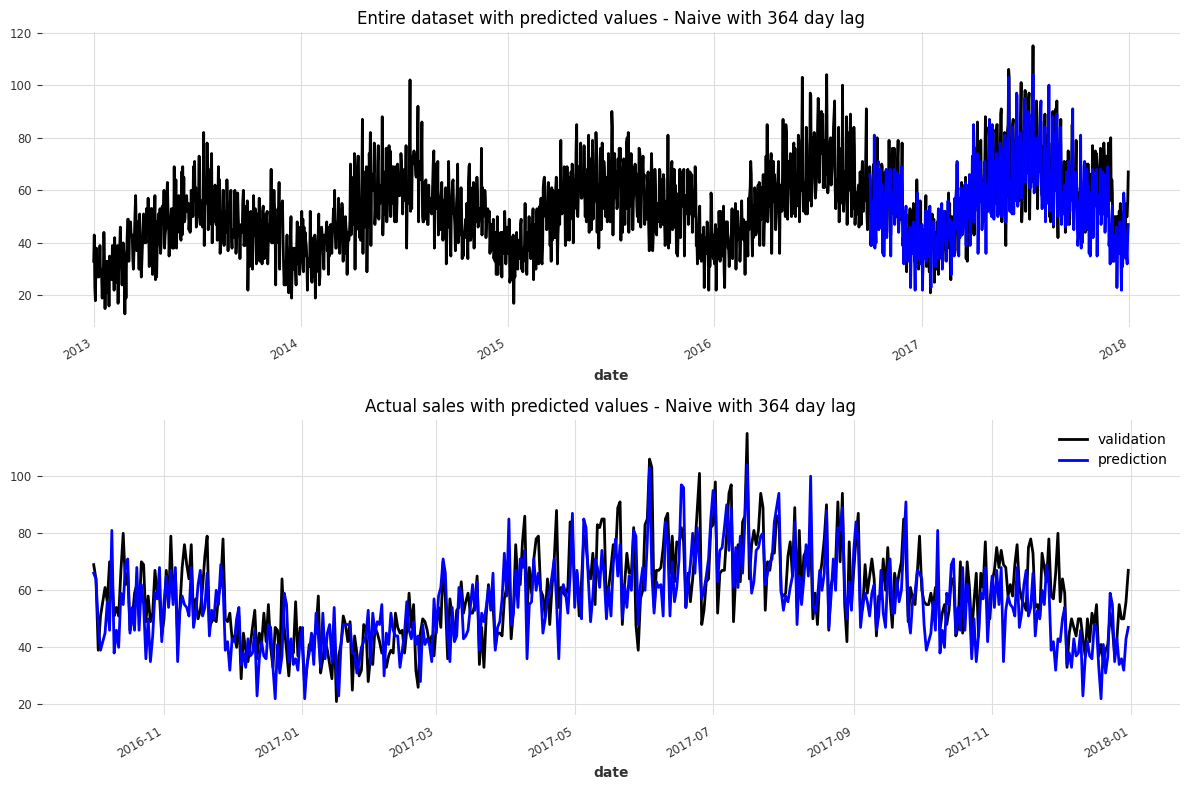

The SMAPE assosciated with the naive seasonal model is: 16.48


In [22]:
LAG = 364
seasonal_model = NaiveSeasonal(K=LAG) #Based on the acf results above
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = seasonal_forecast, 
                  val = val, 
                  model_name = "Naive with 364 day lag")

print(f"The SMAPE assosciated with the naive seasonal model is: {smape(single_series, seasonal_forecast):.2f}")
results_dict['naive_364_lag'] = smape(single_series, seasonal_forecast)

SMAPE isnt too bad, and the model has generalized fairly well for such a simple model. Let's take a closer look at the val/pred portion. 

We can investigate residuals from the models with darts plot_residuals_analysis()

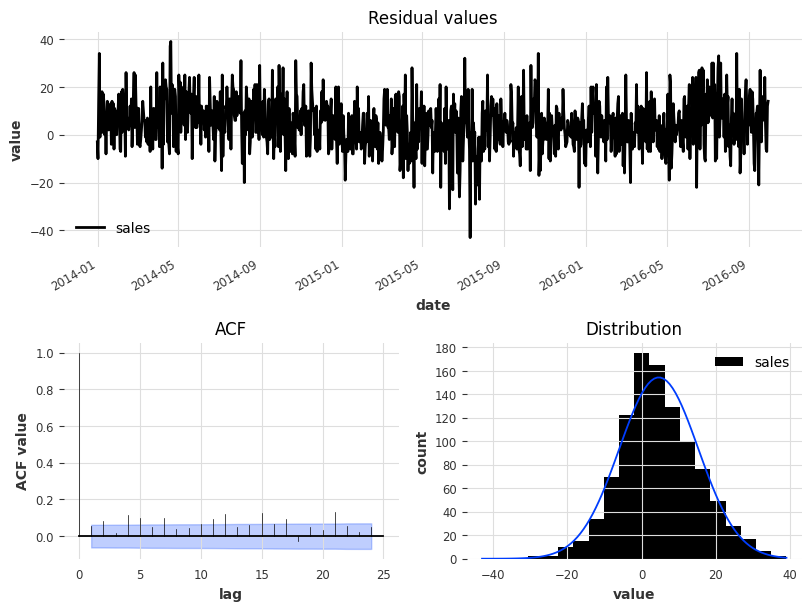

In [23]:
plot_residuals_analysis(seasonal_model.residuals(train))

These graphs show that the naïve method produces forecasts that appear to account for all available information. The mean of the residuals is close to zero and there is no significant correlation in the residuals series. 

 The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the one outlier, and therefore the residual variance can be treated as constant. This can also be seen on the histogram of the residuals. 

 

Lets try some more advanced models.

# ARIMA
## Detmerining p, d, q values

As ARIMA models are only good for stationary data, we should check this first.
 Stationary means that the mean, standard deviation, and variance don't change over time. 

In [24]:
stationarity_test_adf(train)

(-2.5534995304095447,
 0.10299377129198278,
 21,
 1347,
 {'1%': -3.4352139981780865,
  '5%': -2.863688081179776,
  '10%': -2.567913641703717},
 9587.166273116578)

The function returns numerous results, but we are mostly interested in the second value (P-Test). Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary.

We can set the *d* value to 1 to attempt to use the first diff to create stationary data. 

Let's take another look at the ACF graph to derermine the autoeregressive (q) value. 

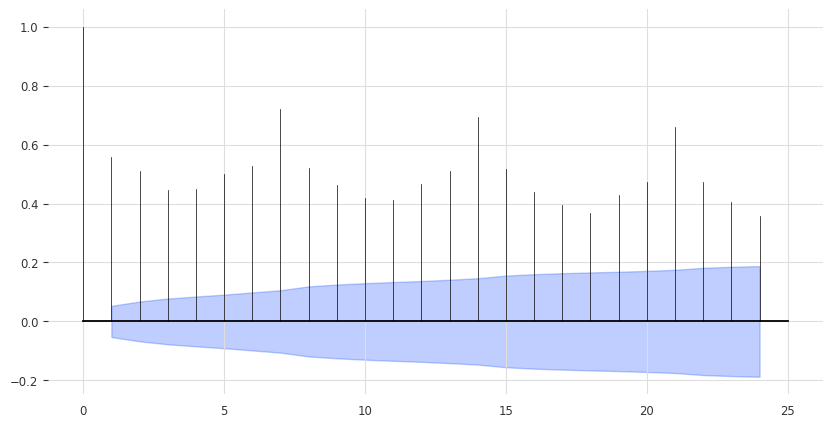

In [25]:
plot_acf(train)

Looks like we can try with q = 7. To gain better insights into the moving average portion (q value) we can look at the PCF plot. 

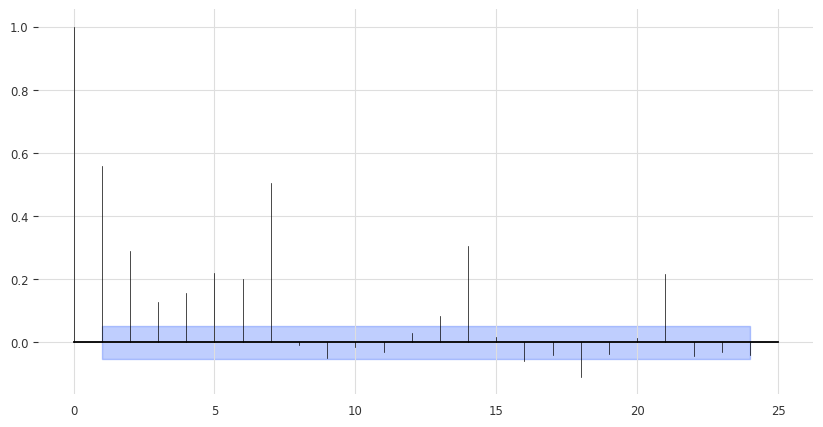

In [26]:
plot_pacf(train)

The first value is most highly correlated, therefore we can try a p value of 1. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


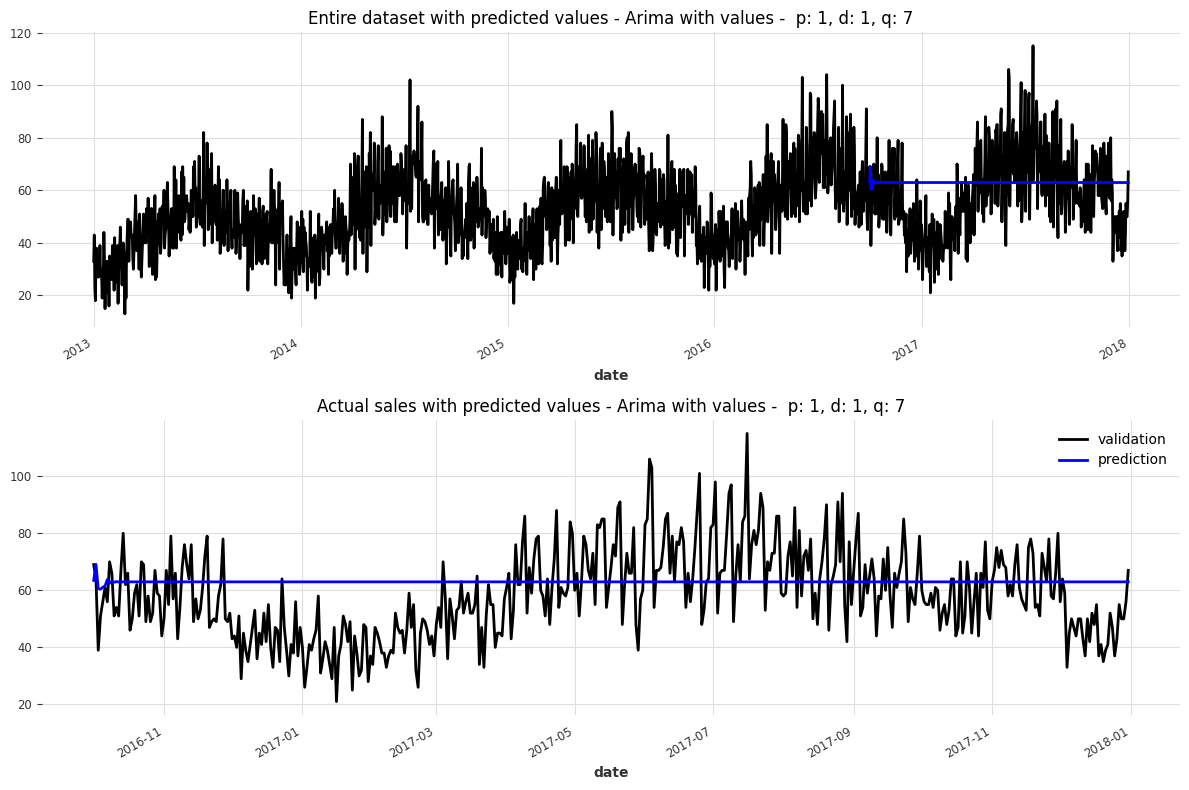

SMAPE for the ARMA model is : 22.66


In [27]:
model_aarima = ARIMA(p = 1, d = 1, q = 7) 
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = prediction_aarima, 
                  val = val, 
                  model_name = "Arima with values -  p: 1, d: 1, q: 7")

print(f"SMAPE for the ARMA model is : \
{smape(single_series,prediction_aarima):.2f}")
results_dict['ARIMA_1_1_7'] = smape(single_series,prediction_aarima)

The SMAPE value is higher and the ARIMA model doesnt seem to have captured the data very well. 
Let's try with including seasonal data. 

In [29]:
model_aarima = ARIMA(p = 1, d = 1, q = 7, seasonal_order = (1,1,1,1)) 
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = prediction_aarima, 
                  val = val, 
                  model_name = "SARIMA (1,1,7)(1,1,1,364)")

print(f"SMAPE for the ARMA model is : \
{smape(single_series,prediction_aarima):.2f}")
results_dict['SARIMA'] = smape(single_series,prediction_aarima)

/opt/miniconda3/envs/sales/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


# Exponential smoothing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


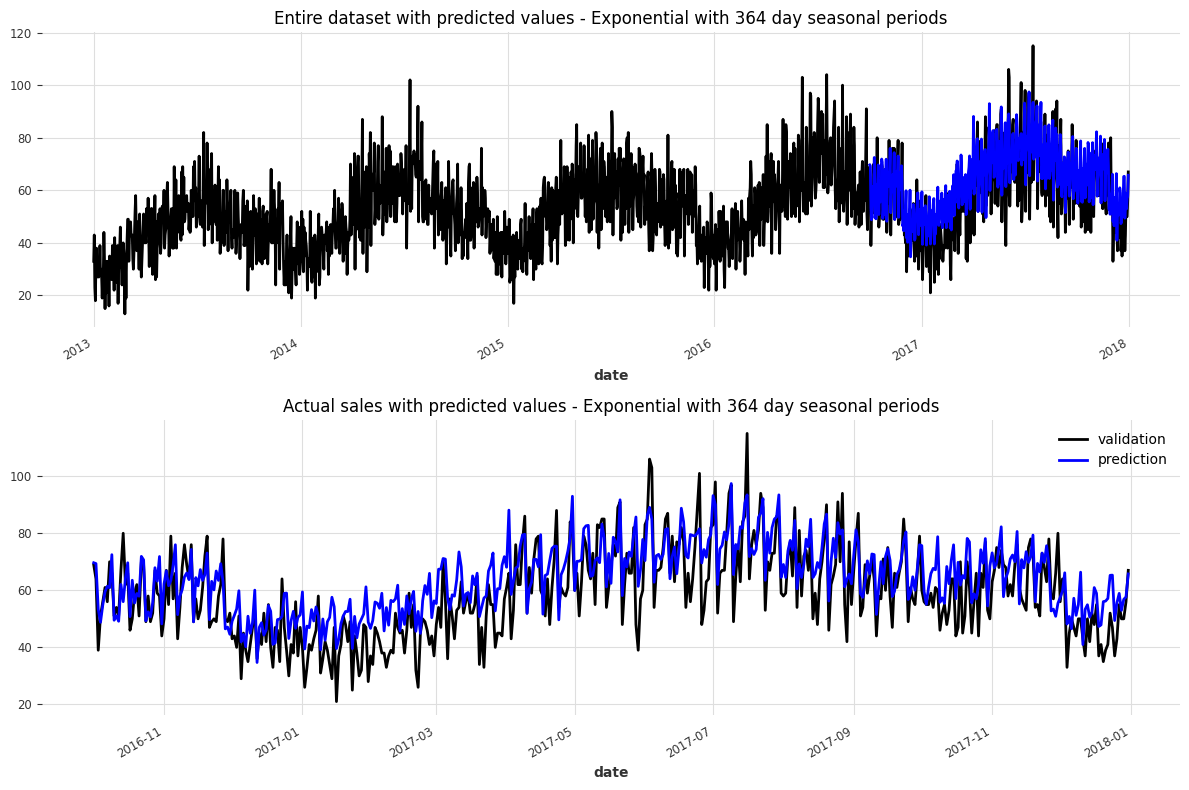

The mean squared error associated with the exponential smoothing model is: 15.48


In [ ]:
model_es = ExponentialSmoothing(seasonal_periods=364)
model_es.fit(train)
es_forecast = model_es.predict(len(val))

plot_training_val(entire_series = single_series, 
                  pred = es_forecast, 
                  val = val, 
                  model_name = "Exponential with 364 day seasonal periods")

print(f"The mean squared error associated with the exponential smoothing model is: {smape(single_series, es_forecast):.2f}")

results_dict['exponential_smoothing'] = smape(single_series, es_forecast)

Decent SMAPE score but has captured the trend better than ARIMA, is also much, much faster than arima when using higher lag values. 

# ML models

## Preprocessing

We need to scale the data between 0 and 1 for most ML algorithms to perform well. 

In [ ]:
df.head()

,store,item,sales,day,month,year,quarter,month_year,month_name
date,,,,,,,,,
2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
2013-01-05,1,1,10,5,1,2013,1,2013-01,May


In [ ]:
scaler = Scaler()
train_scaled = scaler.fit_transform(train)

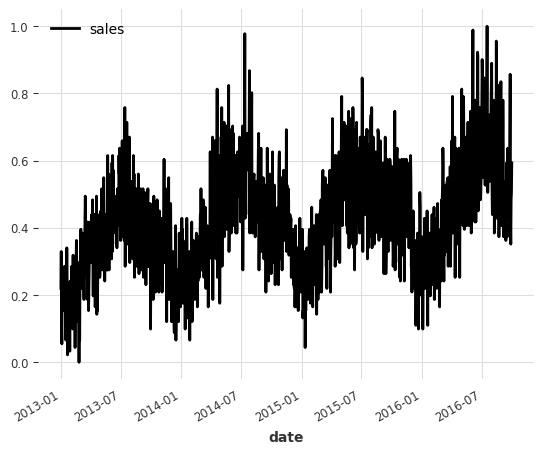

In [ ]:
train_scaled.plot()

## N-BEATS

For simplicity, we will keep most of the hyperparameters of the N-BEATS model as default. 
We will jut adjust: 
* input_chunk_length: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

* output_chunk_length: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

I'm going to stick with my lag value of 364 as input length. 

In [ ]:
RUN_N_BEATS = True #Flag to stop this acidentally running, takes 15 mins
if RUN_N_BEATS:
    model = NBEATSModel(input_chunk_length=364, output_chunk_length=30, random_state=42)
    model.fit([train_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
71.043    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 31/31 [00:08<00:00,  3.60it/s, loss=0.0061, train_loss=0.00723] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 31/31 [00:08<00:00,  3.59it/s, loss=0.0061, train_loss=0.00723]


In [ ]:
if RUN_N_BEATS:
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                    pred = pred, 
                    val = val, 
                    model_name = "N-BEATS - 364")

    print(f"mean squared error for N-BEATS: {smape(single_series, pred):.2f}")
    results_dict['N-BEATS_364'] = smape(single_series, pred)

NameError: name 'RUN_N_BEATS' is not defined

N Beats has defnitely performed the best so far, with the lowest smape and capturing the data trends well. 

# Temporal Fusion Transformer (TFT)

In [ ]:
RUN_TFT = True #Flag to stop this acidentally running, takes 15 mins
if RUN_TFT:
    model = TFTModel(input_chunk_length=364, 
                     output_chunk_length=30, 
                     random_state=42, 
                     add_relative_index = True)

    model.fit([train_scaled], epochs=50, verbose=True);

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
mean squared error for TFT: 15.05


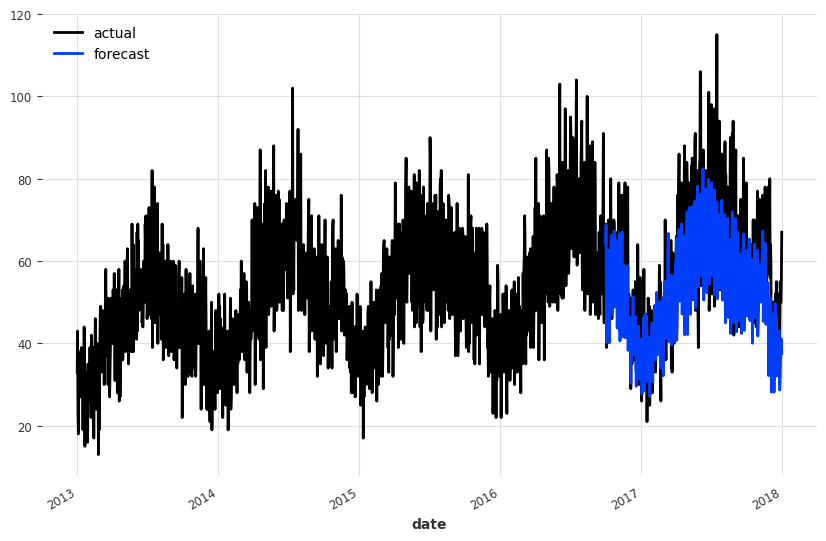

In [ ]:
if RUN_TFT:
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                    pred = pred, 
                    val = val, 
                    model_name = "Temporal Fusion Transformer - 364")

    print(f"mean squared error for TFT: {smape(single_series, pred):.2f}")
    results_dict['TFT_364'] = smape(single_series, pred)

Not quite as good as the N-BEATS model, especially around the seasonal peak seen in summer. 

# Randomforest

Random forests, especially XGBoost, are typically high performers for typical ML projects. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


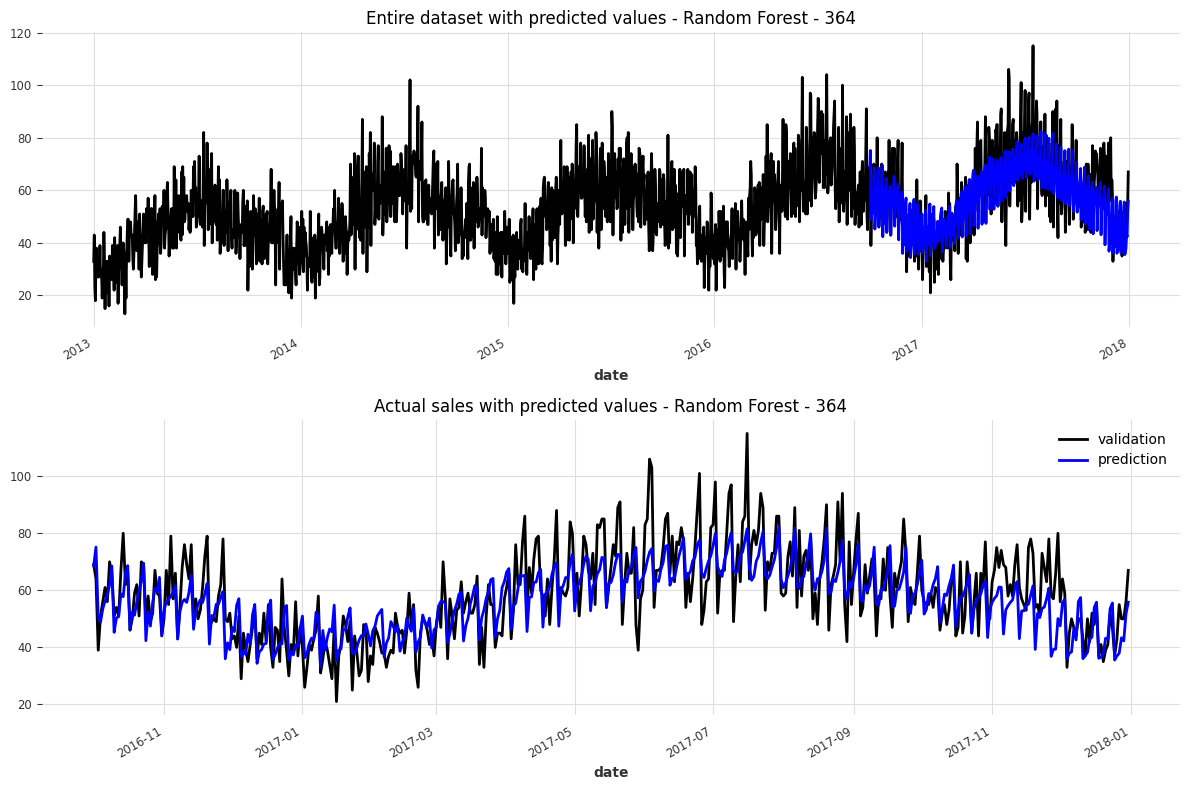

mean squared error for RandomForest: 13.21


In [ ]:
model = RandomForest(lags = 364)
model.fit(train_scaled);
pred = model.predict(series=train_scaled, n=len(val))
# scale back:
pred= scaler.inverse_transform(pred)

plot_training_val(entire_series = single_series, 
                pred = pred, 
                val = val, 
                model_name = "Random Forest - 364")

print(f"mean squared error for RandomForest: {smape(single_series, pred):.2f}")
results_dict['random_forest'] = smape(single_series, pred)

Although generating a low smape, the overall fit of the data doesnt see to be as robust as the N-BEATS or TFT models. It certainly doesnt capture the peaks as well as the N-BEATS model. 

# N-BEATS Model Tuning

As the N-BEATS model has performed the best so far, I'm going to tune this only. 

I'm using Optuna for hyperparameter tuning as it is much smarter/quicker than gridsearch. 

In [ ]:
def objective(trial):
    input_chunk_length = trial.suggest_int('input_chunk_length',7,365)
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    callbacks = [early_stopper]
    pl_trainer_kwargs = {"callbacks": callbacks}
    N_BEATS_model = NBEATSModel(input_chunk_length=input_chunk_length, 
                                output_chunk_length=30, 
                                random_state=42, 
                                pl_trainer_kwargs=pl_trainer_kwargs)
    N_BEATS_model.fit(train_scaled,val_series = val, epochs=100, verbose=True);
    
    pred = N_BEATS_model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)
    smape_result = smape(single_series, pred)
    print(f"SMAPE: {smape_result}")
    return smape_result

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, callbacks=[print_callback])

[I 2022-11-21 08:21:24,359] A new study created in memory with name: no-name-41c1b57c-caef-404a-a4f5-188317bdb09b
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.1 M 
---------------------------------------------------
7.1 M     Trainable params
2.1 K     Non-trainable params
7.1 M     Total params
57.021    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 47/47 [00:08<00:00,  5.28it/s, loss=0.0342, train_loss=0.0241, val_loss=2.7e+3]

Metric val_loss improved. New best score: 2703.323


Epoch 1: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, loss=0.0195, train_loss=0.0162, val_loss=2.43e+3]

Metric val_loss improved by 271.600 >= min_delta = 0.001. New best score: 2431.724


Epoch 2: 100%|██████████| 47/47 [00:08<00:00,  5.40it/s, loss=0.0151, train_loss=0.0163, val_loss=2.14e+3]

Metric val_loss improved by 291.525 >= min_delta = 0.001. New best score: 2140.199


Epoch 3: 100%|██████████| 47/47 [00:08<00:00,  5.59it/s, loss=0.0138, train_loss=0.0128, val_loss=2e+3]   

Metric val_loss improved by 142.198 >= min_delta = 0.001. New best score: 1998.001


Epoch 4: 100%|██████████| 47/47 [00:08<00:00,  5.67it/s, loss=0.0126, train_loss=0.0123, val_loss=1.94e+3]

Metric val_loss improved by 55.055 >= min_delta = 0.001. New best score: 1942.946


Epoch 5: 100%|██████████| 47/47 [00:08<00:00,  5.61it/s, loss=0.0117, train_loss=0.0129, val_loss=1.92e+3]

Metric val_loss improved by 18.807 >= min_delta = 0.001. New best score: 1924.138


Epoch 7: 100%|██████████| 47/47 [00:08<00:00,  5.63it/s, loss=0.0106, train_loss=0.0103, val_loss=1.91e+3] 

Metric val_loss improved by 13.251 >= min_delta = 0.001. New best score: 1910.887


Epoch 8: 100%|██████████| 47/47 [00:08<00:00,  5.66it/s, loss=0.0108, train_loss=0.0122, val_loss=1.88e+3] 

Metric val_loss improved by 31.011 >= min_delta = 0.001. New best score: 1879.876


Epoch 11: 100%|██████████| 47/47 [00:09<00:00,  5.16it/s, loss=0.0101, train_loss=0.00959, val_loss=1.91e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1879.876. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

[I 2022-11-21 08:23:07,953] Trial 0 finished with value: 19.97332340772079 and parameters: {'input_chunk_length': 142}. Best is trial 0 with value: 19.97332340772079.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 19.97332340772079
Current value: 19.97332340772079, Current params: {'input_chunk_length': 142}
Best value: 19.97332340772079, Best params: {'input_chunk_length': 142}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.7 M 
---------------------------------------------------
8.7 M     Trainable params
3.3 K     Non-trainable params
8.7 M     Total params
69.660    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 35/35 [00:08<00:00,  4.11it/s, loss=0.0409, train_loss=0.031, val_loss=2.61e+3]

Metric val_loss improved. New best score: 2609.794


Epoch 1: 100%|██████████| 35/35 [00:07<00:00,  4.38it/s, loss=0.0194, train_loss=0.0152, val_loss=2.31e+3]

Metric val_loss improved by 300.873 >= min_delta = 0.001. New best score: 2308.921


Epoch 2: 100%|██████████| 35/35 [00:07<00:00,  4.52it/s, loss=0.0141, train_loss=0.0166, val_loss=1.94e+3]

Metric val_loss improved by 371.285 >= min_delta = 0.001. New best score: 1937.636


Epoch 3: 100%|██████████| 35/35 [00:07<00:00,  4.50it/s, loss=0.013, train_loss=0.0154, val_loss=1.82e+3] 

Metric val_loss improved by 113.033 >= min_delta = 0.001. New best score: 1824.603


Epoch 4: 100%|██████████| 35/35 [00:07<00:00,  4.46it/s, loss=0.0118, train_loss=0.013, val_loss=1.76e+3]  

Metric val_loss improved by 66.354 >= min_delta = 0.001. New best score: 1758.249


Epoch 5: 100%|██████████| 35/35 [00:07<00:00,  4.54it/s, loss=0.0116, train_loss=0.0135, val_loss=1.62e+3] 

Metric val_loss improved by 136.861 >= min_delta = 0.001. New best score: 1621.387


Epoch 8: 100%|██████████| 35/35 [00:08<00:00,  4.09it/s, loss=0.00983, train_loss=0.0102, val_loss=1.6e+3]  

Metric val_loss improved by 26.118 >= min_delta = 0.001. New best score: 1595.269


Epoch 9: 100%|██████████| 35/35 [00:07<00:00,  4.47it/s, loss=0.0101, train_loss=0.0135, val_loss=1.57e+3] 

Metric val_loss improved by 23.589 >= min_delta = 0.001. New best score: 1571.680


Epoch 12: 100%|██████████| 35/35 [00:09<00:00,  3.75it/s, loss=0.00923, train_loss=0.00808, val_loss=1.56e+3]

Metric val_loss improved by 14.507 >= min_delta = 0.001. New best score: 1557.173


Epoch 13: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s, loss=0.00942, train_loss=0.0116, val_loss=1.52e+3] 

Metric val_loss improved by 34.649 >= min_delta = 0.001. New best score: 1522.524


Epoch 15: 100%|██████████| 35/35 [00:07<00:00,  4.50it/s, loss=0.00935, train_loss=0.0132, val_loss=1.51e+3] 

Metric val_loss improved by 8.207 >= min_delta = 0.001. New best score: 1514.317


Epoch 17: 100%|██████████| 35/35 [00:07<00:00,  4.40it/s, loss=0.00879, train_loss=0.00785, val_loss=1.49e+3]

Metric val_loss improved by 27.331 >= min_delta = 0.001. New best score: 1486.986


Epoch 20: 100%|██████████| 35/35 [00:07<00:00,  4.43it/s, loss=0.00847, train_loss=0.0109, val_loss=1.49e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1486.986. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


[I 2022-11-21 08:25:56,886] Trial 1 finished with value: 13.823936465975075 and parameters: {'input_chunk_length': 343}. Best is trial 1 with value: 13.823936465975075.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 13.823936465975075
Current value: 13.823936465975075, Current params: {'input_chunk_length': 343}
Best value: 13.823936465975075, Best params: {'input_chunk_length': 343}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.4 M 
---------------------------------------------------
7.4 M     Trainable params
2.3 K     Non-trainable params
7.4 M     Total params
58.907    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 45/45 [00:08<00:00,  5.11it/s, loss=0.0266, train_loss=0.0214, val_loss=2.62e+3]

Metric val_loss improved. New best score: 2617.204


Epoch 1: 100%|██████████| 45/45 [00:08<00:00,  5.59it/s, loss=0.016, train_loss=0.015, val_loss=2.22e+3]  

Metric val_loss improved by 393.811 >= min_delta = 0.001. New best score: 2223.393


Epoch 2: 100%|██████████| 45/45 [00:08<00:00,  5.58it/s, loss=0.0143, train_loss=0.0133, val_loss=2.01e+3]

Metric val_loss improved by 210.493 >= min_delta = 0.001. New best score: 2012.900


Epoch 3: 100%|██████████| 45/45 [00:08<00:00,  5.52it/s, loss=0.0128, train_loss=0.0143, val_loss=1.73e+3]

Metric val_loss improved by 286.958 >= min_delta = 0.001. New best score: 1725.943


Epoch 4: 100%|██████████| 45/45 [00:08<00:00,  5.56it/s, loss=0.0118, train_loss=0.0112, val_loss=1.45e+3]

Metric val_loss improved by 271.607 >= min_delta = 0.001. New best score: 1454.335


Epoch 5: 100%|██████████| 45/45 [00:08<00:00,  5.58it/s, loss=0.0119, train_loss=0.0127, val_loss=1.39e+3]

Metric val_loss improved by 67.502 >= min_delta = 0.001. New best score: 1386.833


Epoch 7: 100%|██████████| 45/45 [00:08<00:00,  5.61it/s, loss=0.0108, train_loss=0.011, val_loss=1.34e+3]  

Metric val_loss improved by 48.679 >= min_delta = 0.001. New best score: 1338.154


Epoch 8: 100%|██████████| 45/45 [00:08<00:00,  5.60it/s, loss=0.0101, train_loss=0.0115, val_loss=1.17e+3] 

Metric val_loss improved by 163.873 >= min_delta = 0.001. New best score: 1174.281


Epoch 11: 100%|██████████| 45/45 [00:08<00:00,  5.46it/s, loss=0.00989, train_loss=0.00931, val_loss=1.19e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1174.281. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


[I 2022-11-21 08:27:36,764] Trial 2 finished with value: 18.732013340117653 and parameters: {'input_chunk_length': 172}. Best is trial 1 with value: 13.823936465975075.


SMAPE: 18.732013340117653
Current value: 18.732013340117653, Current params: {'input_chunk_length': 172}
Best value: 13.823936465975075, Best params: {'input_chunk_length': 343}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
70.917    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:08<00:00,  4.19it/s, loss=0.0312, train_loss=0.020, val_loss=3.07e+3]

Metric val_loss improved. New best score: 3072.765


Epoch 1: 100%|██████████| 34/34 [00:07<00:00,  4.37it/s, loss=0.0168, train_loss=0.0154, val_loss=2.63e+3]

Metric val_loss improved by 441.147 >= min_delta = 0.001. New best score: 2631.618


Epoch 2: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s, loss=0.0138, train_loss=0.0116, val_loss=2.41e+3]

Metric val_loss improved by 223.287 >= min_delta = 0.001. New best score: 2408.331


Epoch 3: 100%|██████████| 34/34 [00:07<00:00,  4.44it/s, loss=0.0123, train_loss=0.0116, val_loss=2.25e+3]

Metric val_loss improved by 161.204 >= min_delta = 0.001. New best score: 2247.127


Epoch 4: 100%|██████████| 34/34 [00:07<00:00,  4.47it/s, loss=0.0112, train_loss=0.00981, val_loss=2.2e+3] 

Metric val_loss improved by 49.874 >= min_delta = 0.001. New best score: 2197.253


Epoch 5: 100%|██████████| 34/34 [00:07<00:00,  4.30it/s, loss=0.0102, train_loss=0.00891, val_loss=2.08e+3]

Metric val_loss improved by 114.634 >= min_delta = 0.001. New best score: 2082.620


Epoch 6: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s, loss=0.00967, train_loss=0.0111, val_loss=2.05e+3] 

Metric val_loss improved by 34.296 >= min_delta = 0.001. New best score: 2048.323


Epoch 7: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s, loss=0.00992, train_loss=0.0102, val_loss=2.04e+3] 

Metric val_loss improved by 9.879 >= min_delta = 0.001. New best score: 2038.444


Epoch 9: 100%|██████████| 34/34 [00:07<00:00,  4.44it/s, loss=0.00912, train_loss=0.00851, val_loss=1.97e+3]

Metric val_loss improved by 70.245 >= min_delta = 0.001. New best score: 1968.199


Epoch 10: 100%|██████████| 34/34 [00:07<00:00,  4.35it/s, loss=0.00878, train_loss=0.0082, val_loss=1.96e+3] 

Metric val_loss improved by 9.870 >= min_delta = 0.001. New best score: 1958.330


Epoch 11: 100%|██████████| 34/34 [00:07<00:00,  4.45it/s, loss=0.00873, train_loss=0.00953, val_loss=1.93e+3]

Metric val_loss improved by 32.196 >= min_delta = 0.001. New best score: 1926.134


Epoch 12: 100%|██████████| 34/34 [00:07<00:00,  4.42it/s, loss=0.00876, train_loss=0.00863, val_loss=1.92e+3]

Metric val_loss improved by 4.704 >= min_delta = 0.001. New best score: 1921.430


Epoch 13: 100%|██████████| 34/34 [00:07<00:00,  4.25it/s, loss=0.00859, train_loss=0.0098, val_loss=1.86e+3] 

Metric val_loss improved by 64.050 >= min_delta = 0.001. New best score: 1857.379


Epoch 14: 100%|██████████| 34/34 [00:07<00:00,  4.46it/s, loss=0.00862, train_loss=0.00848, val_loss=1.85e+3]

Metric val_loss improved by 5.659 >= min_delta = 0.001. New best score: 1851.721


Epoch 15: 100%|██████████| 34/34 [00:07<00:00,  4.33it/s, loss=0.00845, train_loss=0.00896, val_loss=1.83e+3]

Metric val_loss improved by 23.578 >= min_delta = 0.001. New best score: 1828.143


Epoch 18: 100%|██████████| 34/34 [00:08<00:00,  3.80it/s, loss=0.00785, train_loss=0.00731, val_loss=1.81e+3]

Metric val_loss improved by 21.772 >= min_delta = 0.001. New best score: 1806.370


Epoch 21: 100%|██████████| 34/34 [00:07<00:00,  4.43it/s, loss=0.00801, train_loss=0.00774, val_loss=1.8e+3] 

Metric val_loss improved by 5.319 >= min_delta = 0.001. New best score: 1801.051


Epoch 23: 100%|██████████| 34/34 [00:07<00:00,  4.41it/s, loss=0.00776, train_loss=0.00656, val_loss=1.75e+3]

Metric val_loss improved by 46.990 >= min_delta = 0.001. New best score: 1754.061


Epoch 25: 100%|██████████| 34/34 [00:07<00:00,  4.42it/s, loss=0.00762, train_loss=0.00799, val_loss=1.75e+3]

Metric val_loss improved by 5.202 >= min_delta = 0.001. New best score: 1748.860


Epoch 28: 100%|██████████| 34/34 [00:07<00:00,  4.45it/s, loss=0.00736, train_loss=0.00757, val_loss=1.75e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1748.860. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

[I 2022-11-21 08:31:23,368] Trial 3 finished with value: 13.25309661484511 and parameters: {'input_chunk_length': 363}. Best is trial 3 with value: 13.25309661484511.



SMAPE: 13.25309661484511
Current value: 13.25309661484511, Current params: {'input_chunk_length': 363}
Best value: 13.25309661484511, Best params: {'input_chunk_length': 363}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.1 M 
---------------------------------------------------
7.1 M     Trainable params
2.1 K     Non-trainable params
7.1 M     Total params
56.643    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 48/48 [00:08<00:00,  5.89it/s, loss=0.0237, train_loss=0.0182, val_loss=4.16e+3]

Metric val_loss improved. New best score: 4162.609


Epoch 1: 100%|██████████| 48/48 [00:07<00:00,  6.06it/s, loss=0.0146, train_loss=0.015, val_loss=3.54e+3] 

Metric val_loss improved by 618.915 >= min_delta = 0.001. New best score: 3543.695


Epoch 2: 100%|██████████| 48/48 [00:08<00:00,  5.69it/s, loss=0.0129, train_loss=0.0135, val_loss=3.44e+3]

Metric val_loss improved by 103.862 >= min_delta = 0.001. New best score: 3439.832


Epoch 3: 100%|██████████| 48/48 [00:08<00:00,  5.67it/s, loss=0.0121, train_loss=0.0121, val_loss=3.36e+3]

Metric val_loss improved by 84.470 >= min_delta = 0.001. New best score: 3355.362


Epoch 4: 100%|██████████| 48/48 [00:08<00:00,  5.93it/s, loss=0.0116, train_loss=0.0114, val_loss=3.28e+3] 

Metric val_loss improved by 77.098 >= min_delta = 0.001. New best score: 3278.265


Epoch 5: 100%|██████████| 48/48 [00:08<00:00,  5.89it/s, loss=0.0108, train_loss=0.0121, val_loss=3.24e+3] 

Metric val_loss improved by 36.677 >= min_delta = 0.001. New best score: 3241.587


Epoch 7: 100%|██████████| 48/48 [00:08<00:00,  5.87it/s, loss=0.00992, train_loss=0.00999, val_loss=3.21e+3]

Metric val_loss improved by 35.587 >= min_delta = 0.001. New best score: 3206.000


Epoch 8: 100%|██████████| 48/48 [00:08<00:00,  5.88it/s, loss=0.00966, train_loss=0.00883, val_loss=3.2e+3] 

Metric val_loss improved by 7.527 >= min_delta = 0.001. New best score: 3198.473


Epoch 11: 100%|██████████| 48/48 [00:08<00:00,  5.89it/s, loss=0.00935, train_loss=0.00861, val_loss=3.35e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3198.473. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

[I 2022-11-21 08:33:03,489] Trial 4 finished with value: 31.387147918738624 and parameters: {'input_chunk_length': 136}. Best is trial 3 with value: 13.25309661484511.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 31.387147918738624
Current value: 31.387147918738624, Current params: {'input_chunk_length': 136}
Best value: 13.25309661484511, Best params: {'input_chunk_length': 363}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.9 M 
---------------------------------------------------
7.9 M     Trainable params
2.7 K     Non-trainable params
7.9 M     Total params
62.868    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [00:08<00:00,  5.23it/s, loss=0.031, train_loss=0.0271, val_loss=5.26e+3]

Metric val_loss improved. New best score: 5261.611


Epoch 1: 100%|██████████| 42/42 [00:08<00:00,  4.96it/s, loss=0.0216, train_loss=0.020, val_loss=4.66e+3] 

Metric val_loss improved by 599.088 >= min_delta = 0.001. New best score: 4662.523


Epoch 2: 100%|██████████| 42/42 [00:08<00:00,  5.23it/s, loss=0.0151, train_loss=0.0166, val_loss=4.23e+3]

Metric val_loss improved by 432.387 >= min_delta = 0.001. New best score: 4230.135


Epoch 3: 100%|██████████| 42/42 [00:07<00:00,  5.31it/s, loss=0.013, train_loss=0.0123, val_loss=3.63e+3] 

Metric val_loss improved by 598.560 >= min_delta = 0.001. New best score: 3631.576


Epoch 4: 100%|██████████| 42/42 [00:08<00:00,  5.24it/s, loss=0.0122, train_loss=0.014, val_loss=3.56e+3]  

Metric val_loss improved by 75.510 >= min_delta = 0.001. New best score: 3556.066


Epoch 6: 100%|██████████| 42/42 [00:08<00:00,  5.22it/s, loss=0.0106, train_loss=0.0114, val_loss=3.37e+3] 

Metric val_loss improved by 188.826 >= min_delta = 0.001. New best score: 3367.240


Epoch 7: 100%|██████████| 42/42 [00:07<00:00,  5.31it/s, loss=0.01, train_loss=0.00958, val_loss=3.3e+3]   

Metric val_loss improved by 66.513 >= min_delta = 0.001. New best score: 3300.727


Epoch 8: 100%|██████████| 42/42 [00:08<00:00,  5.24it/s, loss=0.0101, train_loss=0.0109, val_loss=3.27e+3] 

Metric val_loss improved by 28.528 >= min_delta = 0.001. New best score: 3272.199


Epoch 9: 100%|██████████| 42/42 [00:07<00:00,  5.25it/s, loss=0.00907, train_loss=0.00976, val_loss=3.15e+3]

Metric val_loss improved by 118.936 >= min_delta = 0.001. New best score: 3153.263


Epoch 10: 100%|██████████| 42/42 [00:07<00:00,  5.26it/s, loss=0.00905, train_loss=0.00809, val_loss=3.13e+3]

Metric val_loss improved by 22.223 >= min_delta = 0.001. New best score: 3131.040


Epoch 11: 100%|██████████| 42/42 [00:07<00:00,  5.30it/s, loss=0.00885, train_loss=0.00986, val_loss=3.09e+3]

Metric val_loss improved by 44.224 >= min_delta = 0.001. New best score: 3086.816


Epoch 12: 100%|██████████| 42/42 [00:08<00:00,  4.72it/s, loss=0.00873, train_loss=0.00831, val_loss=3.09e+3]

Metric val_loss improved by 1.272 >= min_delta = 0.001. New best score: 3085.544


Epoch 15: 100%|██████████| 42/42 [00:07<00:00,  5.32it/s, loss=0.00803, train_loss=0.00808, val_loss=3.03e+3]

Metric val_loss improved by 54.536 >= min_delta = 0.001. New best score: 3031.009


Epoch 17: 100%|██████████| 42/42 [00:08<00:00,  5.24it/s, loss=0.00797, train_loss=0.00714, val_loss=2.99e+3]

Metric val_loss improved by 38.405 >= min_delta = 0.001. New best score: 2992.604


Epoch 20: 100%|██████████| 42/42 [00:08<00:00,  5.18it/s, loss=0.00779, train_loss=0.00823, val_loss=3.02e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2992.604. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


[I 2022-11-21 08:35:53,497] Trial 5 finished with value: 14.227451511861572 and parameters: {'input_chunk_length': 235}. Best is trial 3 with value: 13.25309661484511.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 14.227451511861572
Current value: 14.227451511861572, Current params: {'input_chunk_length': 235}
Best value: 13.25309661484511, Best params: {'input_chunk_length': 363}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.1 M 
---------------------------------------------------
7.1 M     Trainable params
2.1 K     Non-trainable params
7.1 M     Total params
56.643    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 48/48 [00:08<00:00,  5.69it/s, loss=0.0237, train_loss=0.0182, val_loss=4.16e+3]

Metric val_loss improved. New best score: 4162.609


Epoch 1: 100%|██████████| 48/48 [00:08<00:00,  5.89it/s, loss=0.0146, train_loss=0.015, val_loss=3.54e+3] 

Metric val_loss improved by 618.915 >= min_delta = 0.001. New best score: 3543.695


Epoch 2: 100%|██████████| 48/48 [00:08<00:00,  5.81it/s, loss=0.0129, train_loss=0.0135, val_loss=3.44e+3]

Metric val_loss improved by 103.862 >= min_delta = 0.001. New best score: 3439.832


Epoch 3: 100%|██████████| 48/48 [00:17<00:00,  2.73it/s, loss=0.0121, train_loss=0.0121, val_loss=3.36e+3]

Metric val_loss improved by 84.470 >= min_delta = 0.001. New best score: 3355.362


Epoch 4: 100%|██████████| 48/48 [00:08<00:00,  5.84it/s, loss=0.0116, train_loss=0.0114, val_loss=3.28e+3] 

Metric val_loss improved by 77.098 >= min_delta = 0.001. New best score: 3278.265


Epoch 5: 100%|██████████| 48/48 [00:08<00:00,  5.60it/s, loss=0.0108, train_loss=0.0121, val_loss=3.24e+3] 

Metric val_loss improved by 36.677 >= min_delta = 0.001. New best score: 3241.587


Epoch 7: 100%|██████████| 48/48 [00:08<00:00,  5.83it/s, loss=0.00992, train_loss=0.00999, val_loss=3.21e+3]

Metric val_loss improved by 35.587 >= min_delta = 0.001. New best score: 3206.000


Epoch 8: 100%|██████████| 48/48 [00:08<00:00,  5.81it/s, loss=0.00966, train_loss=0.00883, val_loss=3.2e+3] 

Metric val_loss improved by 7.527 >= min_delta = 0.001. New best score: 3198.473


Epoch 11: 100%|██████████| 48/48 [00:08<00:00,  5.80it/s, loss=0.00935, train_loss=0.00861, val_loss=3.35e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3198.473. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


[I 2022-11-21 08:37:42,991] Trial 6 finished with value: 31.387147918738624 and parameters: {'input_chunk_length': 136}. Best is trial 3 with value: 13.25309661484511.
GPU available: False, used: False


SMAPE: 31.387147918738624
Current value: 31.387147918738624, Current params: {'input_chunk_length': 136}
Best value: 13.25309661484511, Best params: {'input_chunk_length': 363}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.578    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:07<00:00,  4.84it/s, loss=0.0362, train_loss=0.0274, val_loss=4.34e+3]

Metric val_loss improved. New best score: 4339.511


Epoch 1: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.0211, train_loss=0.0174, val_loss=4.14e+3]

Metric val_loss improved by 200.859 >= min_delta = 0.001. New best score: 4138.652


Epoch 2: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, loss=0.0151, train_loss=0.013, val_loss=3.64e+3] 

Metric val_loss improved by 497.260 >= min_delta = 0.001. New best score: 3641.393


Epoch 3: 100%|██████████| 38/38 [00:07<00:00,  4.98it/s, loss=0.0133, train_loss=0.0144, val_loss=3.26e+3]

Metric val_loss improved by 377.506 >= min_delta = 0.001. New best score: 3263.887


Epoch 4: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, loss=0.0122, train_loss=0.0117, val_loss=3.08e+3]

Metric val_loss improved by 186.079 >= min_delta = 0.001. New best score: 3077.808


Epoch 5: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s, loss=0.011, train_loss=0.0106, val_loss=2.93e+3]  

Metric val_loss improved by 148.352 >= min_delta = 0.001. New best score: 2929.455


Epoch 6: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, loss=0.0113, train_loss=0.0111, val_loss=2.91e+3] 

Metric val_loss improved by 19.701 >= min_delta = 0.001. New best score: 2909.754


Epoch 7: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.0105, train_loss=0.0119, val_loss=2.91e+3] 

Metric val_loss improved by 2.755 >= min_delta = 0.001. New best score: 2906.999


Epoch 9: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s, loss=0.00951, train_loss=0.0089, val_loss=2.87e+3] 

Metric val_loss improved by 38.503 >= min_delta = 0.001. New best score: 2868.496


Epoch 10: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, loss=0.00896, train_loss=0.00922, val_loss=2.84e+3]

Metric val_loss improved by 31.230 >= min_delta = 0.001. New best score: 2837.266


Epoch 11: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s, loss=0.00933, train_loss=0.00888, val_loss=2.8e+3] 

Metric val_loss improved by 40.293 >= min_delta = 0.001. New best score: 2796.973


Epoch 12: 100%|██████████| 38/38 [00:13<00:00,  2.75it/s, loss=0.00885, train_loss=0.00981, val_loss=2.74e+3]

Metric val_loss improved by 57.148 >= min_delta = 0.001. New best score: 2739.825


Epoch 15: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, loss=0.00876, train_loss=0.00796, val_loss=2.8e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2739.825. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


[I 2022-11-21 08:39:55,969] Trial 7 finished with value: 13.066256170705001 and parameters: {'input_chunk_length': 294}. Best is trial 7 with value: 13.066256170705001.


SMAPE: 13.066256170705001
Current value: 13.066256170705001, Current params: {'input_chunk_length': 294}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.4 K     Non-trainable params
8.8 M     Total params
70.414    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 34/34 [00:07<00:00,  4.48it/s, loss=0.0407, train_loss=0.0292, val_loss=1.93e+3]

Metric val_loss improved. New best score: 1928.379


Epoch 1: 100%|██████████| 34/34 [00:07<00:00,  4.53it/s, loss=0.0176, train_loss=0.0158, val_loss=1.77e+3]

Metric val_loss improved by 160.968 >= min_delta = 0.001. New best score: 1767.412


Epoch 2: 100%|██████████| 34/34 [00:07<00:00,  4.59it/s, loss=0.0137, train_loss=0.0143, val_loss=1.51e+3]

Metric val_loss improved by 258.892 >= min_delta = 0.001. New best score: 1508.520


Epoch 3: 100%|██████████| 34/34 [00:07<00:00,  4.55it/s, loss=0.0125, train_loss=0.0114, val_loss=1.35e+3]

Metric val_loss improved by 154.419 >= min_delta = 0.001. New best score: 1354.101


Epoch 4: 100%|██████████| 34/34 [00:07<00:00,  4.61it/s, loss=0.0114, train_loss=0.0107, val_loss=1.23e+3]

Metric val_loss improved by 125.847 >= min_delta = 0.001. New best score: 1228.253


Epoch 5: 100%|██████████| 34/34 [00:07<00:00,  4.59it/s, loss=0.0112, train_loss=0.011, val_loss=1.19e+3]  

Metric val_loss improved by 39.071 >= min_delta = 0.001. New best score: 1189.183


Epoch 7: 100%|██████████| 34/34 [00:07<00:00,  4.50it/s, loss=0.0102, train_loss=0.0116, val_loss=1.15e+3] 

Metric val_loss improved by 40.364 >= min_delta = 0.001. New best score: 1148.819


Epoch 8: 100%|██████████| 34/34 [00:07<00:00,  4.44it/s, loss=0.00984, train_loss=0.00961, val_loss=1.12e+3]

Metric val_loss improved by 25.586 >= min_delta = 0.001. New best score: 1123.233


Epoch 11: 100%|██████████| 34/34 [00:07<00:00,  4.58it/s, loss=0.0095, train_loss=0.00879, val_loss=1.13e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 1123.233. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


[I 2022-11-21 08:41:26,801] Trial 8 finished with value: 15.284898395783639 and parameters: {'input_chunk_length': 355}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SMAPE: 15.284898395783639
Current value: 15.284898395783639, Current params: {'input_chunk_length': 355}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}


HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.1 M 
---------------------------------------------------
8.1 M     Trainable params
2.9 K     Non-trainable params
8.1 M     Total params
64.818    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s, loss=0.0327, train_loss=0.0266, val_loss=3.66e+3]

Metric val_loss improved. New best score: 3664.066


Epoch 1: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s, loss=0.0176, train_loss=0.0172, val_loss=3.31e+3]

Metric val_loss improved by 358.611 >= min_delta = 0.001. New best score: 3305.455


Epoch 2: 100%|██████████| 40/40 [00:08<00:00,  4.68it/s, loss=0.014, train_loss=0.0128, val_loss=2.61e+3] 

Metric val_loss improved by 698.908 >= min_delta = 0.001. New best score: 2606.547


Epoch 3: 100%|██████████| 40/40 [00:08<00:00,  4.88it/s, loss=0.0125, train_loss=0.0116, val_loss=2.4e+3] 

Metric val_loss improved by 202.583 >= min_delta = 0.001. New best score: 2403.964


Epoch 4: 100%|██████████| 40/40 [00:08<00:00,  4.87it/s, loss=0.0115, train_loss=0.0113, val_loss=2.26e+3]

Metric val_loss improved by 145.636 >= min_delta = 0.001. New best score: 2258.328


Epoch 6: 100%|██████████| 40/40 [00:14<00:00,  2.80it/s, loss=0.00998, train_loss=0.0106, val_loss=2.12e+3] 

Metric val_loss improved by 140.691 >= min_delta = 0.001. New best score: 2117.637


Epoch 7: 100%|██████████| 40/40 [00:10<00:00,  3.73it/s, loss=0.00994, train_loss=0.00904, val_loss=2.06e+3]

Metric val_loss improved by 61.242 >= min_delta = 0.001. New best score: 2056.394


Epoch 8: 100%|██████████| 40/40 [00:08<00:00,  4.90it/s, loss=0.00942, train_loss=0.010, val_loss=2.01e+3]  

Metric val_loss improved by 41.770 >= min_delta = 0.001. New best score: 2014.624


Epoch 9: 100%|██████████| 40/40 [00:08<00:00,  4.93it/s, loss=0.00909, train_loss=0.0102, val_loss=1.95e+3] 

Metric val_loss improved by 64.464 >= min_delta = 0.001. New best score: 1950.160


Epoch 12: 100%|██████████| 40/40 [00:08<00:00,  4.89it/s, loss=0.00888, train_loss=0.00917, val_loss=1.96e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1950.160. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


[I 2022-11-21 08:43:22,929] Trial 9 finished with value: 13.732728383632898 and parameters: {'input_chunk_length': 266}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 13.732728383632898
Current value: 13.732728383632898, Current params: {'input_chunk_length': 266}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.224    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 55/55 [00:08<00:00,  6.74it/s, loss=0.0197, train_loss=0.0154, val_loss=2.5e+3]

Metric val_loss improved. New best score: 2498.478


Epoch 2: 100%|██████████| 55/55 [00:08<00:00,  6.78it/s, loss=0.0131, train_loss=0.0119, val_loss=2.49e+3]

Metric val_loss improved by 3.878 >= min_delta = 0.001. New best score: 2494.600


Epoch 3: 100%|██████████| 55/55 [00:08<00:00,  6.74it/s, loss=0.0122, train_loss=0.0131, val_loss=2.41e+3] 

Metric val_loss improved by 79.882 >= min_delta = 0.001. New best score: 2414.718


Epoch 5: 100%|██████████| 55/55 [00:08<00:00,  6.71it/s, loss=0.0117, train_loss=0.0132, val_loss=2.39e+3] 

Metric val_loss improved by 27.554 >= min_delta = 0.001. New best score: 2387.164


Epoch 6: 100%|██████████| 55/55 [00:08<00:00,  6.74it/s, loss=0.0112, train_loss=0.00921, val_loss=2.35e+3]

Metric val_loss improved by 41.042 >= min_delta = 0.001. New best score: 2346.122


Epoch 9: 100%|██████████| 55/55 [00:08<00:00,  6.74it/s, loss=0.0114, train_loss=0.0123, val_loss=2.38e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2346.122. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


[I 2022-11-21 08:44:45,261] Trial 10 finished with value: 37.50040469031444 and parameters: {'input_chunk_length': 18}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 37.50040469031444
Current value: 37.50040469031444, Current params: {'input_chunk_length': 18}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.390    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:07<00:00,  4.86it/s, loss=0.0309, train_loss=0.0234, val_loss=4.82e+3]

Metric val_loss improved. New best score: 4823.259


Epoch 1: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, loss=0.0185, train_loss=0.0168, val_loss=4.26e+3]

Metric val_loss improved by 562.011 >= min_delta = 0.001. New best score: 4261.248


Epoch 2: 100%|██████████| 38/38 [00:09<00:00,  4.09it/s, loss=0.0146, train_loss=0.0125, val_loss=3.76e+3]

Metric val_loss improved by 497.395 >= min_delta = 0.001. New best score: 3763.853


Epoch 3: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.012, train_loss=0.0115, val_loss=3.49e+3] 

Metric val_loss improved by 277.321 >= min_delta = 0.001. New best score: 3486.531


Epoch 4: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s, loss=0.011, train_loss=0.0104, val_loss=3.41e+3]  

Metric val_loss improved by 81.464 >= min_delta = 0.001. New best score: 3405.067


Epoch 5: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s, loss=0.0106, train_loss=0.0117, val_loss=3.3e+3]  

Metric val_loss improved by 103.887 >= min_delta = 0.001. New best score: 3301.180


Epoch 6: 100%|██████████| 38/38 [00:08<00:00,  4.67it/s, loss=0.0111, train_loss=0.00987, val_loss=3.23e+3]

Metric val_loss improved by 75.872 >= min_delta = 0.001. New best score: 3225.308


Epoch 7: 100%|██████████| 38/38 [00:07<00:00,  4.81it/s, loss=0.00946, train_loss=0.00899, val_loss=3.08e+3]

Metric val_loss improved by 143.892 >= min_delta = 0.001. New best score: 3081.416


Epoch 8: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s, loss=0.0089, train_loss=0.0082, val_loss=3.02e+3]  

Metric val_loss improved by 62.640 >= min_delta = 0.001. New best score: 3018.776


Epoch 9: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s, loss=0.0087, train_loss=0.00923, val_loss=2.97e+3] 

Metric val_loss improved by 46.858 >= min_delta = 0.001. New best score: 2971.918


Epoch 10: 100%|██████████| 38/38 [00:07<00:00,  4.84it/s, loss=0.00865, train_loss=0.00839, val_loss=2.95e+3]

Metric val_loss improved by 17.164 >= min_delta = 0.001. New best score: 2954.754


Epoch 12: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, loss=0.00833, train_loss=0.00777, val_loss=2.94e+3]

Metric val_loss improved by 11.834 >= min_delta = 0.001. New best score: 2942.920


Epoch 14: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s, loss=0.00789, train_loss=0.00739, val_loss=2.87e+3]

Metric val_loss improved by 67.968 >= min_delta = 0.001. New best score: 2874.952


Epoch 15: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s, loss=0.00792, train_loss=0.00867, val_loss=2.86e+3]

Metric val_loss improved by 15.767 >= min_delta = 0.001. New best score: 2859.185


Epoch 17: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s, loss=0.00782, train_loss=0.00937, val_loss=2.85e+3]

Metric val_loss improved by 13.687 >= min_delta = 0.001. New best score: 2845.499


Epoch 18: 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, loss=0.00787, train_loss=0.00825, val_loss=2.79e+3]

Metric val_loss improved by 54.456 >= min_delta = 0.001. New best score: 2791.043


Epoch 19: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.00768, train_loss=0.00795, val_loss=2.77e+3]

Metric val_loss improved by 17.290 >= min_delta = 0.001. New best score: 2773.753


Epoch 22: 100%|██████████| 38/38 [00:07<00:00,  4.86it/s, loss=0.00723, train_loss=0.0071, val_loss=2.69e+3] 

Metric val_loss improved by 84.971 >= min_delta = 0.001. New best score: 2688.782


Epoch 23: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, loss=0.00724, train_loss=0.00695, val_loss=2.68e+3]

Metric val_loss improved by 10.045 >= min_delta = 0.001. New best score: 2678.737


Epoch 24: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, loss=0.00717, train_loss=0.00761, val_loss=2.66e+3]

Metric val_loss improved by 19.025 >= min_delta = 0.001. New best score: 2659.712


Epoch 25: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.00714, train_loss=0.00735, val_loss=2.57e+3]

Metric val_loss improved by 89.941 >= min_delta = 0.001. New best score: 2569.771


Epoch 28: 100%|██████████| 38/38 [00:15<00:00,  2.38it/s, loss=0.00695, train_loss=0.00731, val_loss=2.63e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2569.771. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


[I 2022-11-21 08:48:41,981] Trial 11 finished with value: 14.250194670415036 and parameters: {'input_chunk_length': 291}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 14.250194670415036
Current value: 14.250194670415036, Current params: {'input_chunk_length': 291}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.5 M 
---------------------------------------------------
8.5 M     Trainable params
3.2 K     Non-trainable params
8.5 M     Total params
67.773    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 37/37 [00:08<00:00,  4.37it/s, loss=0.0352, train_loss=0.0407, val_loss=3e+3]

Metric val_loss improved. New best score: 2995.182


Epoch 1: 100%|██████████| 37/37 [00:08<00:00,  4.61it/s, loss=0.0181, train_loss=0.0175, val_loss=2.6e+3]

Metric val_loss improved by 399.777 >= min_delta = 0.001. New best score: 2595.405


Epoch 2: 100%|██████████| 37/37 [00:07<00:00,  4.70it/s, loss=0.0148, train_loss=0.0135, val_loss=2.25e+3]

Metric val_loss improved by 342.859 >= min_delta = 0.001. New best score: 2252.546


Epoch 3: 100%|██████████| 37/37 [00:07<00:00,  4.64it/s, loss=0.0126, train_loss=0.00864, val_loss=1.98e+3]

Metric val_loss improved by 272.564 >= min_delta = 0.001. New best score: 1979.982


Epoch 4: 100%|██████████| 37/37 [00:07<00:00,  4.71it/s, loss=0.0111, train_loss=0.00806, val_loss=1.93e+3]

Metric val_loss improved by 49.734 >= min_delta = 0.001. New best score: 1930.248


Epoch 5: 100%|██████████| 37/37 [00:07<00:00,  4.63it/s, loss=0.0104, train_loss=0.010, val_loss=1.82e+3]  

Metric val_loss improved by 111.249 >= min_delta = 0.001. New best score: 1818.998


Epoch 6: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s, loss=0.0103, train_loss=0.010, val_loss=1.71e+3]  

Metric val_loss improved by 111.056 >= min_delta = 0.001. New best score: 1707.942


Epoch 9: 100%|██████████| 37/37 [00:07<00:00,  4.63it/s, loss=0.00926, train_loss=0.00851, val_loss=1.62e+3]

Metric val_loss improved by 85.458 >= min_delta = 0.001. New best score: 1622.484


Epoch 10: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s, loss=0.00903, train_loss=0.00684, val_loss=1.58e+3]

Metric val_loss improved by 41.296 >= min_delta = 0.001. New best score: 1581.188


Epoch 11: 100%|██████████| 37/37 [00:07<00:00,  4.68it/s, loss=0.00881, train_loss=0.00888, val_loss=1.42e+3]

Metric val_loss improved by 159.141 >= min_delta = 0.001. New best score: 1422.047


Epoch 14: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s, loss=0.00825, train_loss=0.00737, val_loss=1.28e+3]

Metric val_loss improved by 140.505 >= min_delta = 0.001. New best score: 1281.542


Epoch 16: 100%|██████████| 37/37 [00:07<00:00,  4.65it/s, loss=0.00823, train_loss=0.0102, val_loss=1.21e+3] 

Metric val_loss improved by 70.239 >= min_delta = 0.001. New best score: 1211.303


Epoch 19: 100%|██████████| 37/37 [00:07<00:00,  4.66it/s, loss=0.00809, train_loss=0.00977, val_loss=1.15e+3]

Metric val_loss improved by 64.264 >= min_delta = 0.001. New best score: 1147.040


Epoch 21: 100%|██████████| 37/37 [00:10<00:00,  3.68it/s, loss=0.00791, train_loss=0.00761, val_loss=1.12e+3]

Metric val_loss improved by 29.135 >= min_delta = 0.001. New best score: 1117.905


Epoch 22: 100%|██████████| 37/37 [00:08<00:00,  4.42it/s, loss=0.00723, train_loss=0.00508, val_loss=1.11e+3]

Metric val_loss improved by 11.741 >= min_delta = 0.001. New best score: 1106.164


Epoch 23: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s, loss=0.00766, train_loss=0.00765, val_loss=1.1e+3] 

Metric val_loss improved by 2.050 >= min_delta = 0.001. New best score: 1104.113


Epoch 24: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s, loss=0.00767, train_loss=0.00918, val_loss=1.09e+3]

Metric val_loss improved by 17.705 >= min_delta = 0.001. New best score: 1086.408


Epoch 25: 100%|██████████| 37/37 [00:07<00:00,  4.67it/s, loss=0.0072, train_loss=0.00407, val_loss=1.06e+3] 

Metric val_loss improved by 28.283 >= min_delta = 0.001. New best score: 1058.125


Epoch 26: 100%|██████████| 37/37 [00:07<00:00,  4.63it/s, loss=0.00749, train_loss=0.00651, val_loss=1.05e+3]

Metric val_loss improved by 4.417 >= min_delta = 0.001. New best score: 1053.708


Epoch 27: 100%|██████████| 37/37 [00:07<00:00,  4.69it/s, loss=0.00737, train_loss=0.00686, val_loss=1.01e+3]

Metric val_loss improved by 40.962 >= min_delta = 0.001. New best score: 1012.746


Epoch 30: 100%|██████████| 37/37 [00:08<00:00,  4.62it/s, loss=0.00753, train_loss=0.00682, val_loss=1.08e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1012.746. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

[I 2022-11-21 08:52:59,244] Trial 12 finished with value: 13.193370246814645 and parameters: {'input_chunk_length': 313}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 13.193370246814645
Current value: 13.193370246814645, Current params: {'input_chunk_length': 313}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.3 M 
---------------------------------------------------
8.3 M     Trainable params
3.0 K     Non-trainable params
8.3 M     Total params
66.516    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:08<00:00,  4.55it/s, loss=0.0366, train_loss=0.0251, val_loss=3.8e+3]

Metric val_loss improved. New best score: 3797.632


Epoch 1: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, loss=0.0201, train_loss=0.0172, val_loss=3.46e+3]

Metric val_loss improved by 334.506 >= min_delta = 0.001. New best score: 3463.126


Epoch 2: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, loss=0.0148, train_loss=0.0141, val_loss=3e+3]   

Metric val_loss improved by 458.201 >= min_delta = 0.001. New best score: 3004.925


Epoch 3: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, loss=0.0135, train_loss=0.0123, val_loss=2.66e+3]

Metric val_loss improved by 348.411 >= min_delta = 0.001. New best score: 2656.515


Epoch 4: 100%|██████████| 38/38 [00:07<00:00,  4.84it/s, loss=0.012, train_loss=0.0113, val_loss=2.54e+3] 

Metric val_loss improved by 112.822 >= min_delta = 0.001. New best score: 2543.692


Epoch 5: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s, loss=0.0113, train_loss=0.0116, val_loss=2.42e+3]

Metric val_loss improved by 119.130 >= min_delta = 0.001. New best score: 2424.562


Epoch 6: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, loss=0.0102, train_loss=0.00894, val_loss=2.42e+3]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 2424.507


Epoch 7: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s, loss=0.00956, train_loss=0.00943, val_loss=2.36e+3]

Metric val_loss improved by 61.372 >= min_delta = 0.001. New best score: 2363.135


Epoch 8: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, loss=0.00965, train_loss=0.00983, val_loss=2.29e+3]

Metric val_loss improved by 72.855 >= min_delta = 0.001. New best score: 2290.279


Epoch 9: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s, loss=0.0094, train_loss=0.00925, val_loss=2.28e+3] 

Metric val_loss improved by 14.883 >= min_delta = 0.001. New best score: 2275.396


Epoch 12: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s, loss=0.00883, train_loss=0.00769, val_loss=2.33e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2275.396. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


[I 2022-11-21 08:54:42,021] Trial 13 finished with value: 13.104009437892373 and parameters: {'input_chunk_length': 293}. Best is trial 7 with value: 13.066256170705001.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 13.104009437892373
Current value: 13.104009437892373, Current params: {'input_chunk_length': 293}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.8 M 
---------------------------------------------------
7.8 M     Trainable params
2.7 K     Non-trainable params
7.8 M     Total params
62.491    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [00:09<00:00,  4.34it/s, loss=0.031, train_loss=0.0257, val_loss=3.85e+3]

Metric val_loss improved. New best score: 3845.341


Epoch 1: 100%|██████████| 42/42 [00:07<00:00,  5.30it/s, loss=0.018, train_loss=0.0163, val_loss=3.5e+3]  

Metric val_loss improved by 342.080 >= min_delta = 0.001. New best score: 3503.260


Epoch 2: 100%|██████████| 42/42 [00:08<00:00,  4.79it/s, loss=0.014, train_loss=0.0135, val_loss=2.22e+3]

Metric val_loss improved by 1279.969 >= min_delta = 0.001. New best score: 2223.291


Epoch 3: 100%|██████████| 42/42 [00:07<00:00,  5.31it/s, loss=0.0132, train_loss=0.0143, val_loss=2.12e+3]

Metric val_loss improved by 99.148 >= min_delta = 0.001. New best score: 2124.143


Epoch 4: 100%|██████████| 42/42 [00:08<00:00,  5.13it/s, loss=0.0121, train_loss=0.013, val_loss=2e+3]    

Metric val_loss improved by 129.007 >= min_delta = 0.001. New best score: 1995.136


Epoch 5: 100%|██████████| 42/42 [00:07<00:00,  5.39it/s, loss=0.011, train_loss=0.0109, val_loss=1.66e+3]

Metric val_loss improved by 337.446 >= min_delta = 0.001. New best score: 1657.690


Epoch 6: 100%|██████████| 42/42 [00:07<00:00,  5.31it/s, loss=0.0105, train_loss=0.0099, val_loss=1.59e+3] 

Metric val_loss improved by 64.815 >= min_delta = 0.001. New best score: 1592.876


Epoch 7: 100%|██████████| 42/42 [00:07<00:00,  5.25it/s, loss=0.00984, train_loss=0.0106, val_loss=1.52e+3] 

Metric val_loss improved by 75.061 >= min_delta = 0.001. New best score: 1517.815


Epoch 8: 100%|██████████| 42/42 [00:08<00:00,  5.22it/s, loss=0.00962, train_loss=0.00931, val_loss=1.46e+3]

Metric val_loss improved by 60.634 >= min_delta = 0.001. New best score: 1457.181


Epoch 9: 100%|██████████| 42/42 [00:08<00:00,  5.24it/s, loss=0.00902, train_loss=0.0104, val_loss=1.42e+3] 

Metric val_loss improved by 36.428 >= min_delta = 0.001. New best score: 1420.752


Epoch 11: 100%|██████████| 42/42 [00:07<00:00,  5.34it/s, loss=0.00883, train_loss=0.00963, val_loss=1.38e+3]

Metric val_loss improved by 38.574 >= min_delta = 0.001. New best score: 1382.178


Epoch 14: 100%|██████████| 42/42 [00:07<00:00,  5.35it/s, loss=0.00843, train_loss=0.00801, val_loss=1.37e+3]

Metric val_loss improved by 10.275 >= min_delta = 0.001. New best score: 1371.903


Epoch 17: 100%|██████████| 42/42 [00:08<00:00,  5.22it/s, loss=0.00816, train_loss=0.00807, val_loss=1.35e+3]

Metric val_loss improved by 23.371 >= min_delta = 0.001. New best score: 1348.532


Epoch 18: 100%|██████████| 42/42 [00:07<00:00,  5.31it/s, loss=0.00786, train_loss=0.00806, val_loss=1.34e+3]

Metric val_loss improved by 12.595 >= min_delta = 0.001. New best score: 1335.937


Epoch 21: 100%|██████████| 42/42 [00:12<00:00,  3.47it/s, loss=0.00771, train_loss=0.00791, val_loss=1.31e+3]

Metric val_loss improved by 30.325 >= min_delta = 0.001. New best score: 1305.612


Epoch 23: 100%|██████████| 42/42 [00:08<00:00,  5.22it/s, loss=0.0077, train_loss=0.00751, val_loss=1.26e+3] 

Metric val_loss improved by 45.987 >= min_delta = 0.001. New best score: 1259.625


Epoch 24: 100%|██████████| 42/42 [00:07<00:00,  5.34it/s, loss=0.00749, train_loss=0.0075, val_loss=1.24e+3] 

Metric val_loss improved by 15.725 >= min_delta = 0.001. New best score: 1243.901


Epoch 27: 100%|██████████| 42/42 [00:07<00:00,  5.35it/s, loss=0.00738, train_loss=0.00729, val_loss=1.28e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1243.901. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


[I 2022-11-21 08:58:38,208] Trial 14 finished with value: 15.3839670846042 and parameters: {'input_chunk_length': 229}. Best is trial 7 with value: 13.066256170705001.


SMAPE: 15.3839670846042
Current value: 15.3839670846042, Current params: {'input_chunk_length': 229}
Best value: 13.066256170705001, Best params: {'input_chunk_length': 294}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.8 M 
---------------------------------------------------
7.8 M     Trainable params
2.6 K     Non-trainable params
7.8 M     Total params
62.114    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 42/42 [00:07<00:00,  5.26it/s, loss=0.0295, train_loss=0.0268, val_loss=4.18e+3]

Metric val_loss improved. New best score: 4183.914


Epoch 1: 100%|██████████| 42/42 [00:07<00:00,  5.29it/s, loss=0.0175, train_loss=0.017, val_loss=3.96e+3] 

Metric val_loss improved by 221.564 >= min_delta = 0.001. New best score: 3962.350


Epoch 2: 100%|██████████| 42/42 [00:07<00:00,  5.40it/s, loss=0.0144, train_loss=0.0142, val_loss=3.54e+3]

Metric val_loss improved by 424.707 >= min_delta = 0.001. New best score: 3537.643


Epoch 3: 100%|██████████| 42/42 [00:07<00:00,  5.38it/s, loss=0.0142, train_loss=0.015, val_loss=3.31e+3] 

Metric val_loss improved by 224.384 >= min_delta = 0.001. New best score: 3313.259


Epoch 4: 100%|██████████| 42/42 [00:07<00:00,  5.41it/s, loss=0.0118, train_loss=0.0118, val_loss=2.98e+3]

Metric val_loss improved by 331.233 >= min_delta = 0.001. New best score: 2982.026


Epoch 5: 100%|██████████| 42/42 [00:07<00:00,  5.35it/s, loss=0.0112, train_loss=0.0107, val_loss=2.89e+3] 

Metric val_loss improved by 92.903 >= min_delta = 0.001. New best score: 2889.123


Epoch 6: 100%|██████████| 42/42 [00:07<00:00,  5.37it/s, loss=0.0109, train_loss=0.0106, val_loss=2.8e+3]  

Metric val_loss improved by 91.893 >= min_delta = 0.001. New best score: 2797.231


Epoch 7: 100%|██████████| 42/42 [00:07<00:00,  5.44it/s, loss=0.00987, train_loss=0.00989, val_loss=2.74e+3]

Metric val_loss improved by 61.678 >= min_delta = 0.001. New best score: 2735.552


Epoch 8: 100%|██████████| 42/42 [00:07<00:00,  5.40it/s, loss=0.00972, train_loss=0.00986, val_loss=2.68e+3]

Metric val_loss improved by 57.927 >= min_delta = 0.001. New best score: 2677.625


Epoch 11: 100%|██████████| 42/42 [00:07<00:00,  5.36it/s, loss=0.00886, train_loss=0.00932, val_loss=2.63e+3]

Metric val_loss improved by 51.848 >= min_delta = 0.001. New best score: 2625.777


Epoch 14: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s, loss=0.00858, train_loss=0.00985, val_loss=2.7e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2625.777. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

[I 2022-11-21 09:00:46,114] Trial 15 finished with value: 12.948115346207262 and parameters: {'input_chunk_length': 223}. Best is trial 15 with value: 12.948115346207262.



SMAPE: 12.948115346207262
Current value: 12.948115346207262, Current params: {'input_chunk_length': 223}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.7 M 
---------------------------------------------------
7.7 M     Trainable params
2.6 K     Non-trainable params
7.7 M     Total params
61.674    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 43/43 [00:08<00:00,  5.24it/s, loss=0.0349, train_loss=0.0179, val_loss=4.5e+3]

Metric val_loss improved. New best score: 4498.061


Epoch 1: 100%|██████████| 43/43 [00:07<00:00,  5.49it/s, loss=0.0207, train_loss=0.016, val_loss=3.97e+3]

Metric val_loss improved by 526.261 >= min_delta = 0.001. New best score: 3971.799


Epoch 2: 100%|██████████| 43/43 [00:07<00:00,  5.47it/s, loss=0.0152, train_loss=0.0153, val_loss=3.58e+3]

Metric val_loss improved by 391.497 >= min_delta = 0.001. New best score: 3580.303


Epoch 3: 100%|██████████| 43/43 [00:07<00:00,  5.45it/s, loss=0.0137, train_loss=0.0116, val_loss=3.28e+3]

Metric val_loss improved by 297.415 >= min_delta = 0.001. New best score: 3282.888


Epoch 4: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s, loss=0.0129, train_loss=0.0148, val_loss=3.22e+3]

Metric val_loss improved by 60.398 >= min_delta = 0.001. New best score: 3222.490


Epoch 5: 100%|██████████| 43/43 [00:07<00:00,  5.45it/s, loss=0.0114, train_loss=0.0124, val_loss=3.21e+3]

Metric val_loss improved by 10.911 >= min_delta = 0.001. New best score: 3211.579


Epoch 6: 100%|██████████| 43/43 [00:07<00:00,  5.53it/s, loss=0.0117, train_loss=0.0124, val_loss=3.09e+3]

Metric val_loss improved by 117.611 >= min_delta = 0.001. New best score: 3093.967


Epoch 7: 100%|██████████| 43/43 [00:07<00:00,  5.39it/s, loss=0.0103, train_loss=0.0112, val_loss=3.08e+3] 

Metric val_loss improved by 11.955 >= min_delta = 0.001. New best score: 3082.012


Epoch 8: 100%|██████████| 43/43 [00:08<00:00,  5.25it/s, loss=0.0107, train_loss=0.00964, val_loss=3e+3]   

Metric val_loss improved by 78.980 >= min_delta = 0.001. New best score: 3003.032


Epoch 9: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s, loss=0.00997, train_loss=0.012, val_loss=2.94e+3]

Metric val_loss improved by 58.658 >= min_delta = 0.001. New best score: 2944.374


Epoch 10: 100%|██████████| 43/43 [00:07<00:00,  5.50it/s, loss=0.0103, train_loss=0.0125, val_loss=2.77e+3] 

Metric val_loss improved by 174.526 >= min_delta = 0.001. New best score: 2769.848


Epoch 12: 100%|██████████| 43/43 [00:07<00:00,  5.41it/s, loss=0.00911, train_loss=0.0105, val_loss=2.77e+3] 

Metric val_loss improved by 0.739 >= min_delta = 0.001. New best score: 2769.110


Epoch 13: 100%|██████████| 43/43 [00:07<00:00,  5.50it/s, loss=0.0089, train_loss=0.0106, val_loss=2.69e+3]  

Metric val_loss improved by 76.540 >= min_delta = 0.001. New best score: 2692.570


Epoch 15: 100%|██████████| 43/43 [00:07<00:00,  5.53it/s, loss=0.00866, train_loss=0.00874, val_loss=2.58e+3]

Metric val_loss improved by 117.313 >= min_delta = 0.001. New best score: 2575.257


Epoch 18: 100%|██████████| 43/43 [00:07<00:00,  5.47it/s, loss=0.00832, train_loss=0.00872, val_loss=2.75e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2575.257. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


[I 2022-11-21 09:03:17,249] Trial 16 finished with value: 13.786746951865686 and parameters: {'input_chunk_length': 216}. Best is trial 15 with value: 12.948115346207262.


SMAPE: 13.786746951865686
Current value: 13.786746951865686, Current params: {'input_chunk_length': 216}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.5 M 
---------------------------------------------------
6.5 M     Trainable params
1.7 K     Non-trainable params
6.5 M     Total params
52.368    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 52/52 [00:08<00:00,  6.13it/s, loss=0.0281, train_loss=0.0229, val_loss=4e+3]

Metric val_loss improved. New best score: 3999.381


Epoch 1: 100%|██████████| 52/52 [00:08<00:00,  5.92it/s, loss=0.0169, train_loss=0.0161, val_loss=3.31e+3]

Metric val_loss improved by 690.524 >= min_delta = 0.001. New best score: 3308.857


Epoch 2: 100%|██████████| 52/52 [00:08<00:00,  5.87it/s, loss=0.0144, train_loss=0.0123, val_loss=3.23e+3]

Metric val_loss improved by 76.733 >= min_delta = 0.001. New best score: 3232.125


Epoch 4: 100%|██████████| 52/52 [00:08<00:00,  5.95it/s, loss=0.0122, train_loss=0.0114, val_loss=3.19e+3] 

Metric val_loss improved by 37.511 >= min_delta = 0.001. New best score: 3194.613


Epoch 5: 100%|██████████| 52/52 [00:08<00:00,  6.04it/s, loss=0.0114, train_loss=0.0102, val_loss=3.16e+3] 

Metric val_loss improved by 31.642 >= min_delta = 0.001. New best score: 3162.971


Epoch 6: 100%|██████████| 52/52 [00:08<00:00,  6.16it/s, loss=0.0111, train_loss=0.0101, val_loss=3.08e+3] 

Metric val_loss improved by 84.979 >= min_delta = 0.001. New best score: 3077.992


Epoch 9: 100%|██████████| 52/52 [00:08<00:00,  6.08it/s, loss=0.0107, train_loss=0.0115, val_loss=3.14e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 3077.992. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


[I 2022-11-21 09:04:44,314] Trial 17 finished with value: 27.415542300311145 and parameters: {'input_chunk_length': 68}. Best is trial 15 with value: 12.948115346207262.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 27.415542300311145
Current value: 27.415542300311145, Current params: {'input_chunk_length': 68}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.4 M 
---------------------------------------------------
7.4 M     Trainable params
2.4 K     Non-trainable params
7.4 M     Total params
59.410    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 45/45 [00:09<00:00,  4.67it/s, loss=0.0279, train_loss=0.0205, val_loss=4.1e+3]

Metric val_loss improved. New best score: 4104.564


Epoch 1: 100%|██████████| 45/45 [00:08<00:00,  5.51it/s, loss=0.0172, train_loss=0.0184, val_loss=3.46e+3]

Metric val_loss improved by 645.669 >= min_delta = 0.001. New best score: 3458.896


Epoch 2: 100%|██████████| 45/45 [00:08<00:00,  5.53it/s, loss=0.0146, train_loss=0.0129, val_loss=3.01e+3]

Metric val_loss improved by 446.621 >= min_delta = 0.001. New best score: 3012.274


Epoch 3: 100%|██████████| 45/45 [00:08<00:00,  5.48it/s, loss=0.0135, train_loss=0.0157, val_loss=2.65e+3]

Metric val_loss improved by 366.986 >= min_delta = 0.001. New best score: 2645.289


Epoch 4: 100%|██████████| 45/45 [00:08<00:00,  5.46it/s, loss=0.0122, train_loss=0.0147, val_loss=2.49e+3]

Metric val_loss improved by 153.192 >= min_delta = 0.001. New best score: 2492.097


Epoch 5: 100%|██████████| 45/45 [00:08<00:00,  5.52it/s, loss=0.0121, train_loss=0.0117, val_loss=2.34e+3]

Metric val_loss improved by 148.727 >= min_delta = 0.001. New best score: 2343.370


Epoch 6: 100%|██████████| 45/45 [00:08<00:00,  5.54it/s, loss=0.0112, train_loss=0.0137, val_loss=2.27e+3] 

Metric val_loss improved by 72.373 >= min_delta = 0.001. New best score: 2270.997


Epoch 8: 100%|██████████| 45/45 [00:08<00:00,  5.45it/s, loss=0.00987, train_loss=0.00889, val_loss=2.23e+3]

Metric val_loss improved by 42.886 >= min_delta = 0.001. New best score: 2228.111


Epoch 11: 100%|██████████| 45/45 [00:08<00:00,  5.54it/s, loss=0.00957, train_loss=0.0104, val_loss=2.35e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 2228.111. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


[I 2022-11-21 09:06:24,978] Trial 18 finished with value: 23.12868645808008 and parameters: {'input_chunk_length': 180}. Best is trial 15 with value: 12.948115346207262.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 23.12868645808008
Current value: 23.12868645808008, Current params: {'input_chunk_length': 180}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.0 M 
---------------------------------------------------
8.0 M     Trainable params
2.8 K     Non-trainable params
8.0 M     Total params
64.126    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 40/40 [00:07<00:00,  5.03it/s, loss=0.0351, train_loss=0.026, val_loss=4.53e+3]

Metric val_loss improved. New best score: 4527.529


Epoch 1: 100%|██████████| 40/40 [00:16<00:00,  2.49it/s, loss=0.0199, train_loss=0.017, val_loss=4.35e+3] 

Metric val_loss improved by 180.850 >= min_delta = 0.001. New best score: 4346.679


Epoch 2: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s, loss=0.0151, train_loss=0.0139, val_loss=3.93e+3]

Metric val_loss improved by 416.825 >= min_delta = 0.001. New best score: 3929.855


Epoch 3: 100%|██████████| 40/40 [00:07<00:00,  5.13it/s, loss=0.0129, train_loss=0.0133, val_loss=3.52e+3]

Metric val_loss improved by 412.196 >= min_delta = 0.001. New best score: 3517.659


Epoch 4: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s, loss=0.0118, train_loss=0.0112, val_loss=3.43e+3]

Metric val_loss improved by 86.810 >= min_delta = 0.001. New best score: 3430.849


Epoch 5: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s, loss=0.0109, train_loss=0.0112, val_loss=3.37e+3] 

Metric val_loss improved by 58.831 >= min_delta = 0.001. New best score: 3372.017


Epoch 6: 100%|██████████| 40/40 [00:07<00:00,  5.16it/s, loss=0.011, train_loss=0.0102, val_loss=3.25e+3]  

Metric val_loss improved by 119.173 >= min_delta = 0.001. New best score: 3252.844


Epoch 9: 100%|██████████| 40/40 [00:07<00:00,  5.21it/s, loss=0.00936, train_loss=0.00837, val_loss=3.18e+3]

Metric val_loss improved by 72.416 >= min_delta = 0.001. New best score: 3180.428


Epoch 11: 100%|██████████| 40/40 [00:07<00:00,  5.19it/s, loss=0.00886, train_loss=0.00914, val_loss=3.17e+3]

Metric val_loss improved by 12.446 >= min_delta = 0.001. New best score: 3167.982


Epoch 14: 100%|██████████| 40/40 [00:07<00:00,  5.15it/s, loss=0.00859, train_loss=0.00856, val_loss=3.23e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 3167.982. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


[I 2022-11-21 09:08:31,222] Trial 19 finished with value: 15.111453401269815 and parameters: {'input_chunk_length': 255}. Best is trial 15 with value: 12.948115346207262.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


SMAPE: 15.111453401269815
Current value: 15.111453401269815, Current params: {'input_chunk_length': 255}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.8 M 
---------------------------------------------------
6.7 M     Trainable params
1.8 K     Non-trainable params
6.8 M     Total params
54.002    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 50/50 [00:08<00:00,  5.98it/s, loss=0.0266, train_loss=0.0211, val_loss=4.04e+3]

Metric val_loss improved. New best score: 4036.403


Epoch 1: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s, loss=0.0171, train_loss=0.0139, val_loss=3.34e+3]

Metric val_loss improved by 695.581 >= min_delta = 0.001. New best score: 3340.822


Epoch 2: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s, loss=0.0137, train_loss=0.015, val_loss=3.23e+3] 

Metric val_loss improved by 106.675 >= min_delta = 0.001. New best score: 3234.147


Epoch 5: 100%|██████████| 50/50 [00:08<00:00,  6.05it/s, loss=0.0112, train_loss=0.0105, val_loss=3.28e+3] 

Monitored metric val_loss did not improve in the last 3 records. Best score: 3234.147. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

[I 2022-11-21 09:09:22,214] Trial 20 finished with value: 27.536578469988065 and parameters: {'input_chunk_length': 94}. Best is trial 15 with value: 12.948115346207262.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



SMAPE: 27.536578469988065
Current value: 27.536578469988065, Current params: {'input_chunk_length': 94}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.4 M 
---------------------------------------------------
8.4 M     Trainable params
3.1 K     Non-trainable params
8.4 M     Total params
66.893    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 38/38 [00:08<00:00,  4.71it/s, loss=0.0335, train_loss=0.0258, val_loss=3.92e+3]

Metric val_loss improved. New best score: 3921.094


Epoch 1: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, loss=0.0181, train_loss=0.018, val_loss=3.58e+3] 

Metric val_loss improved by 338.612 >= min_delta = 0.001. New best score: 3582.482


Epoch 2: 100%|██████████| 38/38 [00:09<00:00,  4.16it/s, loss=0.0146, train_loss=0.0157, val_loss=3.04e+3]

Metric val_loss improved by 539.779 >= min_delta = 0.001. New best score: 3042.703


Epoch 3: 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, loss=0.0126, train_loss=0.0127, val_loss=2.79e+3]

Metric val_loss improved by 250.020 >= min_delta = 0.001. New best score: 2792.683


Epoch 4: 100%|██████████| 38/38 [00:08<00:00,  4.72it/s, loss=0.0113, train_loss=0.0131, val_loss=2.64e+3] 

Metric val_loss improved by 153.124 >= min_delta = 0.001. New best score: 2639.559


Epoch 5: 100%|██████████| 38/38 [00:07<00:00,  4.88it/s, loss=0.011, train_loss=0.00962, val_loss=2.6e+3]  

Metric val_loss improved by 41.393 >= min_delta = 0.001. New best score: 2598.166


Epoch 6: 100%|██████████| 38/38 [00:07<00:00,  4.76it/s, loss=0.01, train_loss=0.00992, val_loss=2.53e+3] 

Metric val_loss improved by 65.923 >= min_delta = 0.001. New best score: 2532.243


Epoch 7: 100%|██████████| 38/38 [00:07<00:00,  4.86it/s, loss=0.0099, train_loss=0.00939, val_loss=2.51e+3] 

Metric val_loss improved by 17.766 >= min_delta = 0.001. New best score: 2514.476


Epoch 8: 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, loss=0.00905, train_loss=0.00906, val_loss=2.49e+3]

Metric val_loss improved by 28.891 >= min_delta = 0.001. New best score: 2485.585


Epoch 9: 100%|██████████| 38/38 [00:07<00:00,  4.83it/s, loss=0.0095, train_loss=0.00843, val_loss=2.4e+3]  

Metric val_loss improved by 87.076 >= min_delta = 0.001. New best score: 2398.509


Epoch 10: 100%|██████████| 38/38 [00:08<00:00,  4.74it/s, loss=0.00913, train_loss=0.00875, val_loss=2.36e+3]

Metric val_loss improved by 38.152 >= min_delta = 0.001. New best score: 2360.357


Epoch 12: 100%|██████████| 38/38 [00:07<00:00,  4.85it/s, loss=0.0088, train_loss=0.0103, val_loss=2.31e+3]  

Metric val_loss improved by 51.348 >= min_delta = 0.001. New best score: 2309.009


Epoch 15: 100%|██████████| 38/38 [00:07<00:00,  4.82it/s, loss=0.00877, train_loss=0.00741, val_loss=2.42e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2309.009. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

[I 2022-11-21 09:11:30,696] Trial 21 finished with value: 16.728987218837794 and parameters: {'input_chunk_length': 299}. Best is trial 15 with value: 12.948115346207262.



SMAPE: 16.728987218837794
Current value: 16.728987218837794, Current params: {'input_chunk_length': 299}
Best value: 12.948115346207262, Best params: {'input_chunk_length': 223}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.5 M 
---------------------------------------------------
8.5 M     Trainable params
3.2 K     Non-trainable params
8.5 M     Total params
68.025    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 36/36 [00:07<00:00,  4.76it/s, loss=0.029, train_loss=0.0231, val_loss=4.3e+3]

Metric val_loss improved. New best score: 4304.504


Epoch 1: 100%|██████████| 36/36 [00:07<00:00,  4.74it/s, loss=0.0185, train_loss=0.0145, val_loss=3.77e+3]

Metric val_loss improved by 534.441 >= min_delta = 0.001. New best score: 3770.063


Epoch 2: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.0139, train_loss=0.0136, val_loss=3.2e+3] 

Metric val_loss improved by 568.252 >= min_delta = 0.001. New best score: 3201.811


Epoch 3: 100%|██████████| 36/36 [00:07<00:00,  4.56it/s, loss=0.0123, train_loss=0.0111, val_loss=3.09e+3]

Metric val_loss improved by 114.826 >= min_delta = 0.001. New best score: 3086.984


Epoch 4: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.011, train_loss=0.0118, val_loss=2.92e+3]  

Metric val_loss improved by 170.001 >= min_delta = 0.001. New best score: 2916.984


Epoch 5: 100%|██████████| 36/36 [00:07<00:00,  4.79it/s, loss=0.0104, train_loss=0.00917, val_loss=2.91e+3]

Metric val_loss improved by 3.526 >= min_delta = 0.001. New best score: 2913.458


Epoch 6: 100%|██████████| 36/36 [00:08<00:00,  4.44it/s, loss=0.00995, train_loss=0.0104, val_loss=2.81e+3] 

Metric val_loss improved by 102.327 >= min_delta = 0.001. New best score: 2811.131


Epoch 8: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=0.00943, train_loss=0.0106, val_loss=2.76e+3] 

Metric val_loss improved by 53.909 >= min_delta = 0.001. New best score: 2757.222


Epoch 9: 100%|██████████| 36/36 [00:15<00:00,  2.27it/s, loss=0.00934, train_loss=0.00991, val_loss=2.74e+3]

Metric val_loss improved by 14.894 >= min_delta = 0.001. New best score: 2742.328


Epoch 10: 100%|██████████| 36/36 [00:07<00:00,  4.71it/s, loss=0.00916, train_loss=0.00994, val_loss=2.71e+3]

Metric val_loss improved by 28.931 >= min_delta = 0.001. New best score: 2713.397


Epoch 11: 100%|██████████| 36/36 [00:07<00:00,  4.74it/s, loss=0.00894, train_loss=0.00839, val_loss=2.66e+3]

Metric val_loss improved by 56.970 >= min_delta = 0.001. New best score: 2656.427


Epoch 12: 100%|██████████| 36/36 [00:07<00:00,  4.76it/s, loss=0.00858, train_loss=0.00846, val_loss=2.61e+3]

Metric val_loss improved by 43.217 >= min_delta = 0.001. New best score: 2613.210


Epoch 13: 100%|██████████| 36/36 [00:07<00:00,  4.73it/s, loss=0.00832, train_loss=0.00864, val_loss=2.59e+3]

Metric val_loss improved by 24.262 >= min_delta = 0.001. New best score: 2588.948


Epoch 14: 100%|██████████| 36/36 [00:07<00:00,  4.70it/s, loss=0.00887, train_loss=0.00888, val_loss=2.56e+3]

Metric val_loss improved by 33.779 >= min_delta = 0.001. New best score: 2555.169


Epoch 15: 100%|██████████| 36/36 [00:07<00:00,  4.75it/s, loss=0.00818, train_loss=0.00863, val_loss=2.54e+3]

Metric val_loss improved by 15.527 >= min_delta = 0.001. New best score: 2539.642


Epoch 16: 100%|██████████| 36/36 [00:07<00:00,  4.74it/s, loss=0.00792, train_loss=0.00795, val_loss=2.51e+3]

Metric val_loss improved by 32.351 >= min_delta = 0.001. New best score: 2507.291


Epoch 18: 100%|██████████| 36/36 [00:07<00:00,  4.73it/s, loss=0.00797, train_loss=0.00718, val_loss=2.45e+3]

Metric val_loss improved by 62.032 >= min_delta = 0.001. New best score: 2445.259


Epoch 19: 100%|██████████| 36/36 [00:07<00:00,  4.63it/s, loss=0.00758, train_loss=0.00821, val_loss=2.43e+3]

Metric val_loss improved by 14.191 >= min_delta = 0.001. New best score: 2431.068


Epoch 21: 100%|██████████| 36/36 [00:07<00:00,  4.72it/s, loss=0.00767, train_loss=0.00764, val_loss=2.42e+3]

Metric val_loss improved by 10.860 >= min_delta = 0.001. New best score: 2420.209


Epoch 23: 100%|██████████| 36/36 [00:07<00:00,  4.67it/s, loss=0.00783, train_loss=0.00807, val_loss=2.4e+3] 

Metric val_loss improved by 23.561 >= min_delta = 0.001. New best score: 2396.648


Epoch 24: 100%|██████████| 36/36 [00:07<00:00,  4.77it/s, loss=0.008, train_loss=0.00777, val_loss=2.4e+3]  

Metric val_loss improved by 0.861 >= min_delta = 0.001. New best score: 2395.787


Epoch 25: 100%|██████████| 36/36 [00:07<00:00,  4.72it/s, loss=0.00739, train_loss=0.00657, val_loss=2.39e+3]

Metric val_loss improved by 4.115 >= min_delta = 0.001. New best score: 2391.671


Epoch 27: 100%|██████████| 36/36 [00:07<00:00,  4.69it/s, loss=0.00748, train_loss=0.00742, val_loss=2.31e+3]

Metric val_loss improved by 80.739 >= min_delta = 0.001. New best score: 2310.932


Epoch 30: 100%|██████████| 36/36 [00:07<00:00,  4.69it/s, loss=0.00714, train_loss=0.00719, val_loss=2.31e+3]

Metric val_loss improved by 4.539 >= min_delta = 0.001. New best score: 2306.393


Epoch 33: 100%|██████████| 36/36 [00:07<00:00,  4.69it/s, loss=0.00656, train_loss=0.00644, val_loss=2.39e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 2306.393. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

[I 2022-11-21 09:16:04,267] Trial 22 finished with value: 12.169588567625215 and parameters: {'input_chunk_length': 317}. Best is trial 22 with value: 12.169588567625215.



SMAPE: 12.169588567625215
Current value: 12.169588567625215, Current params: {'input_chunk_length': 317}
Best value: 12.169588567625215, Best params: {'input_chunk_length': 317}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.6 M 
---------------------------------------------------
8.6 M     Trainable params
3.2 K     Non-trainable params
8.6 M     Total params
68.653    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 36/36 [00:07<00:00,  4.52it/s, loss=0.033, train_loss=0.0236, val_loss=3.8e+3]

Metric val_loss improved. New best score: 3803.065


Epoch 1: 100%|██████████| 36/36 [00:07<00:00,  4.61it/s, loss=0.0178, train_loss=0.0162, val_loss=3.56e+3]

Metric val_loss improved by 245.908 >= min_delta = 0.001. New best score: 3557.157


Epoch 2: 100%|██████████| 36/36 [00:07<00:00,  4.51it/s, loss=0.0142, train_loss=0.0128, val_loss=2.81e+3]

Metric val_loss improved by 748.261 >= min_delta = 0.001. New best score: 2808.896


Epoch 3: 100%|██████████| 36/36 [00:07<00:00,  4.59it/s, loss=0.0123, train_loss=0.0127, val_loss=2.38e+3]

Metric val_loss improved by 425.156 >= min_delta = 0.001. New best score: 2383.740


Epoch 6: 100%|██████████| 36/36 [00:08<00:00,  4.37it/s, loss=0.0106, train_loss=0.011, val_loss=2.39e+3]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 2383.740. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

[I 2022-11-21 09:17:00,644] Trial 23 finished with value: 15.492425894305809 and parameters: {'input_chunk_length': 327}. Best is trial 22 with value: 12.169588567625215.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores



SMAPE: 15.492425894305809
Current value: 15.492425894305809, Current params: {'input_chunk_length': 327}
Best value: 12.169588567625215, Best params: {'input_chunk_length': 317}


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.1 M 
---------------------------------------------------
8.1 M     Trainable params
2.9 K     Non-trainable params
8.1 M     Total params
65.069    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 39/39 [00:07<00:00,  4.91it/s, loss=0.0341, train_loss=0.0239, val_loss=3.1e+3]

Metric val_loss improved. New best score: 3103.748


Epoch 1: 100%|██████████| 39/39 [00:07<00:00,  4.99it/s, loss=0.0178, train_loss=0.0169, val_loss=2.82e+3]

Metric val_loss improved by 288.561 >= min_delta = 0.001. New best score: 2815.187


Epoch 2: 100%|██████████| 39/39 [00:08<00:00,  4.81it/s, loss=0.0144, train_loss=0.013, val_loss=2.31e+3] 

Metric val_loss improved by 509.298 >= min_delta = 0.001. New best score: 2305.889


Epoch 3: 100%|██████████| 39/39 [00:07<00:00,  5.03it/s, loss=0.0127, train_loss=0.0141, val_loss=2.05e+3]

Metric val_loss improved by 259.258 >= min_delta = 0.001. New best score: 2046.630


Epoch 4: 100%|██████████| 39/39 [00:07<00:00,  4.92it/s, loss=0.0114, train_loss=0.0116, val_loss=1.9e+3] 

Metric val_loss improved by 145.168 >= min_delta = 0.001. New best score: 1901.462


Epoch 5: 100%|██████████| 39/39 [00:07<00:00,  4.93it/s, loss=0.0111, train_loss=0.011, val_loss=1.77e+3] 

Metric val_loss improved by 129.396 >= min_delta = 0.001. New best score: 1772.066


Epoch 6: 100%|██████████| 39/39 [00:07<00:00,  4.96it/s, loss=0.0109, train_loss=0.0112, val_loss=1.73e+3]

Metric val_loss improved by 43.063 >= min_delta = 0.001. New best score: 1729.003


Epoch 7: 100%|██████████| 39/39 [00:07<00:00,  5.03it/s, loss=0.0102, train_loss=0.0103, val_loss=1.71e+3] 

Metric val_loss improved by 19.749 >= min_delta = 0.001. New best score: 1709.254


Epoch 8: 100%|██████████| 39/39 [00:07<00:00,  4.88it/s, loss=0.00979, train_loss=0.00954, val_loss=1.66e+3]

Metric val_loss improved by 52.777 >= min_delta = 0.001. New best score: 1656.477


Epoch 10: 100%|██████████| 39/39 [00:07<00:00,  4.97it/s, loss=0.00868, train_loss=0.00776, val_loss=1.64e+3]

Metric val_loss improved by 14.766 >= min_delta = 0.001. New best score: 1641.711


Epoch 13: 100%|██████████| 39/39 [00:16<00:00,  2.38it/s, loss=0.00897, train_loss=0.00862, val_loss=1.64e+3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 1641.711. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


[I 2022-11-21 09:19:00,593] Trial 24 finished with value: 13.69270765017311 and parameters: {'input_chunk_length': 270}. Best is trial 22 with value: 12.169588567625215.


SMAPE: 13.69270765017311
Current value: 13.69270765017311, Current params: {'input_chunk_length': 270}
Best value: 12.169588567625215, Best params: {'input_chunk_length': 317}


In [ ]:
print(study.best_trial.value)

12.169588567625215


In [ ]:
print(study.best_trial.params)

{'input_chunk_length': 317}


The best input chunk length is 317, corresponding to a SMAPE score of 12.16%. This is actually slightly better than the winning Kaggle score (12.58015), althoug there has been 4 years of devlopment since the competition ran. 

Let's run the model with the best params again, and check the output plot. 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.5 M 
---------------------------------------------------
8.5 M     Trainable params
3.2 K     Non-trainable params
8.5 M     Total params
68.025    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s, loss=0.00824, train_loss=0.00848]

`Trainer.fit` stopped: `max_epochs=15` reached.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


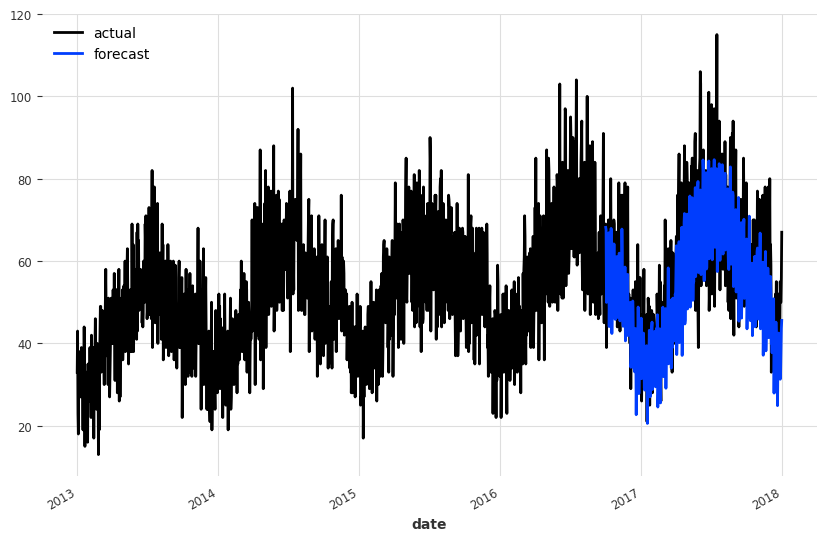

In [ ]:
RUN_N_BEATS_BEST_PARAMS = True #Flag to stop this acidentally running, takes 15 mins
if RUN_N_BEATS_BEST_PARAMS:
    model = NBEATSModel(input_chunk_length=study.best_trial.params['input_chunk_length'], output_chunk_length=30, random_state=42)
    model.fit([train_scaled], epochs=15, verbose=True)
    pred = model.predict(series=train_scaled, n=len(val))
    # scale back:
    pred= scaler.inverse_transform(pred)

    plot_training_val(entire_series = single_series, 
                pred = pred, 
                val = val, 
                model_name = f"N-BEATS Best Params - Input chunk length: {study.best_trial.params['input_chunk_length']} ")
    
    results_dict['N-BEATS_best_params'] = smape(single_series, pred)

# Results Visualization 

Let's compare the results of the various algorithms. 

Text(0.5, 0, 'SMAPE Value')

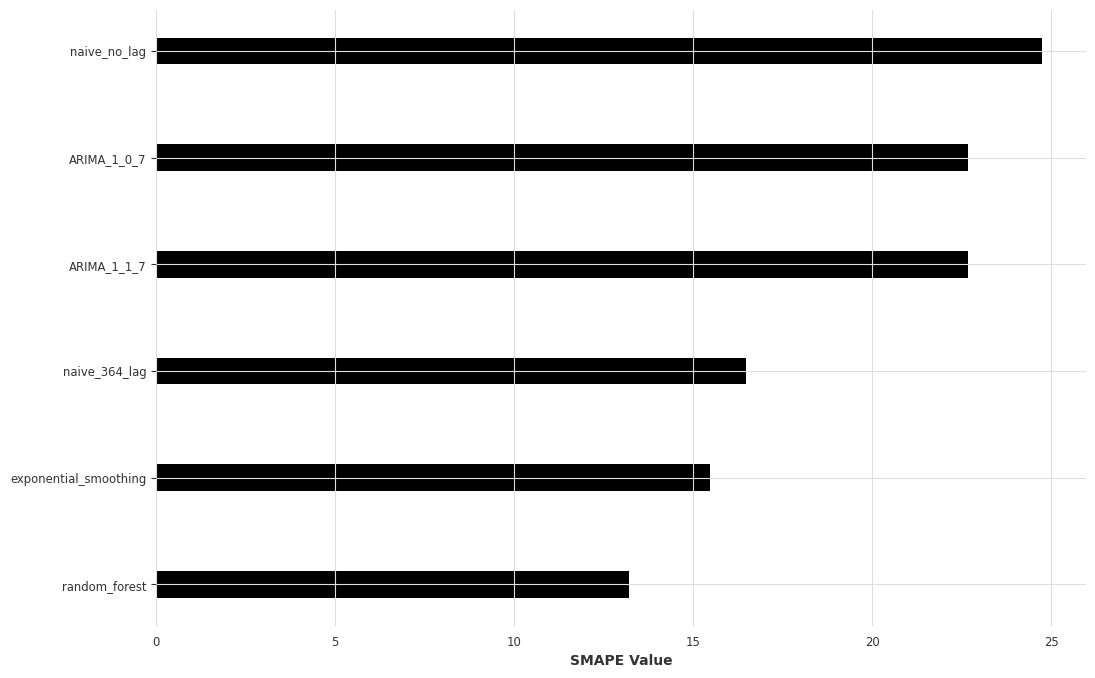

In [ ]:
results_dict_sorted = {k: v for k, v in sorted(results_dict.items(), key=lambda item: item[1])}
fig, ax = plt.subplots(figsize = (12,8))
ax.barh(list(results_dict_sorted.keys()), list(results_dict_sorted.values()),height = 0.25)
ax.set_xlabel("SMAPE Value")